In this code we take Oct 1st, 2021 - Dec31st 2024 as training and Jan 1st, 2025 - Aug 21st, 2025 as test. So we are doing a "forward regression" (FR). Can't use 'year' as feature due to overfitting, so we do detrending (DT) using year first.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Import required libraries
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
#load data/AllWeathDTypes_NWPP_10yrs.csv as a dataframe
DFX = pd.read_csv("data/AllWeath_regNWPP_2021-2025.csv").drop(['electric_cdd', 'electric_hdd', 'gas_cdd', 'gas_hdd', 'population_cdd', 'population_hdd'], axis=1)
DFY = pd.read_csv("data/RTLoad_MIDC+NW_10yrs.csv").drop(['objectid','yes_objectid','iso'], axis=1)
#subtract 7 hours from datetime to convert from UTC to PST
station_utc_offset = {"Tacoma": 7, "Boise": 6, "Eugene": 7, "Portland": 7, "NWPP": 7, "Vancouver": 7, "Yakima": 7, "Pendleton": 7, "Billings": 6, "Medford": 7,
    "Reno": 7, "Salt Lake City": 6, "Great Falls": 6, "Klamath Falls": 7, "Spokane": 7, "Seattle": 7}
DFY['datetime'] = pd.to_datetime(DFY['datetime'])
DFY['datetime'] = DFY['datetime'] - pd.Timedelta(hours=7)
DFX['datetime'] = pd.to_datetime(DFX['datetime'])
if set(DFX['station_name'].unique()) != set(station_utc_offset.keys()):
    raise ValueError("Station names in DFX do not match keys in station_utc_offset!")
DFX['datetime'] = DFX.apply(lambda row: row['datetime'] - pd.Timedelta(hours=station_utc_offset.get(row['station_name'],7)), axis=1)

In [5]:
DFX = DFX[DFX['temperature'] >= 0]

Running regression for 9 zones: ['Puget Sound Energy, Inc.' 'BPA' 'Avista Corporation'
 'Seattle City Light' 'PACW-TAC' 'Idaho Power Company' 'AVRN'
 'Portland General Electric Company'
 'City of Tacoma, Department of Public Utilities']

--- Processing Puget Sound Energy, Inc. ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (28512, 213), Test data shape: (5598, 213)
R-squared on training data: 0.9817
R-squared on test data: 0.9510
MAPE on training data: 2.06%
MAPE on test data: 3.41%

--- Processing BPA ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 07:00:00


C:\Users\kumar\AppData\Local\Temp\ipykernel_45284\760852125.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append({


Training data shape: (28512, 213), Test data shape: (5598, 213)
R-squared on training data: 0.9779
R-squared on test data: 0.9162
MAPE on training data: 1.80%
MAPE on test data: 3.45%

--- Processing Avista Corporation ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (24993, 213), Test data shape: (5598, 213)
R-squared on training data: 0.9795
R-squared on test data: 0.9497
MAPE on training data: 2.24%
MAPE on test data: 3.50%

--- Processing Seattle City Light ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (28512, 213), Test data shape: (5598, 213)
R-squared on training data: 0.9802
R-squared on test data: 0.9391
MAPE on training data: 2.01%
MAPE on test data: 3.80%

--- Processing PACW-TAC ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (28512, 213), Test data shape: (5598, 213)
R-squared on training data: 0.9758
R-squared on test data: 0.9506
MAPE on training data: 2.10%
MA

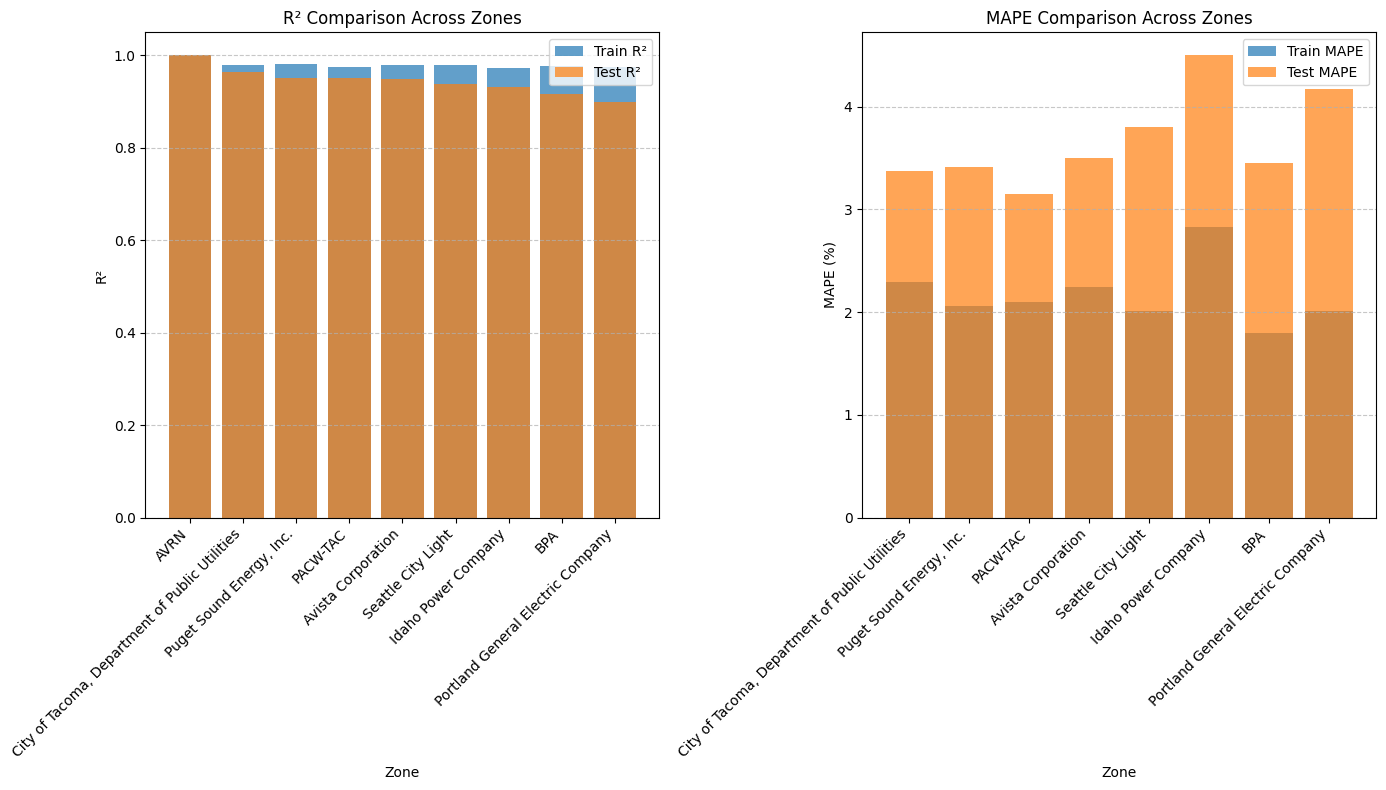

In [4]:
# Get all unique names from DFY
unique_names = DFY['name'].unique()
print(f"Running regression for {len(unique_names)} zones: {unique_names}")

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Name', 'Train R²', 'Test R²', 'Train MAPE', 'Test MAPE'])

# Loop through each name
for name in unique_names:
    print(f"\n--- Processing {name} ---")
    
    # Use the totalload function to calculate the total load
    start_date = pd.to_datetime('2021-10-01')
    end_date = DFY[DFY['name']==name].dropna()['datetime'].max()

    print(f"Data ranges from {start_date} to {end_date}")
    dfY = DFY[(DFY['name']==name) & (DFY['datetime'] >= start_date) & (DFY['datetime'] <= end_date)].dropna().rename(columns={"avgvalue":"load"}).drop(columns=['name'])
    DFX_filtered = DFX[(DFX['datetime'] >= start_date) & (DFX['datetime'] <= end_date)]
    
    # Check if we have enough data
    if len(dfY) < 100:
        print(f"Not enough data for {name}, skipping")
        continue
    
    # Drop nans from dfY['load']
    initial_len = len(dfY)
    dfY = dfY.dropna(subset=['load'])
    dropped_len = initial_len - len(dfY)
    if dropped_len > 0:
        print(f"Dropped {dropped_len} rows with NaN load values")
    
    # Get unique stations and columns to pivot (reuse the existing code)
    stations = DFX_filtered['station_name'].unique()
    columns_to_pivot = DFX_filtered.columns.difference(['datetime', 'station_name'])

    # Create a list to store dataframes for each station
    station_dfs = []

    # For each station, create a dataframe with properly named columns
    for station in stations:
        # Filter data for this station
        station_data = DFX_filtered[DFX_filtered['station_name'] == station]
        
        # Set datetime as index
        station_data = station_data.set_index('datetime')
        
        # Drop the station_name column
        station_data = station_data.drop('station_name', axis=1)
        
        # Rename columns to include station name
        station_data = station_data.rename(columns={col: f"{col}_{station}" for col in station_data.columns})
        
        # Add to list
        station_dfs.append(station_data)

    # Concatenate all station dataframes horizontally
    dfX = pd.concat(station_dfs, axis=1).reset_index()
    
    # Extract date and time components
    dfX['year'] = dfX['datetime'].dt.year
    dfX['month'] = dfX['datetime'].dt.month
    dfX['date'] = dfX['datetime'].dt.day
    dfX['day'] = dfX['datetime'].dt.dayofweek
    dfX['time'] = dfX['datetime'].dt.hour
    
    # Merge X and Y
    df_XY = pd.merge(dfX, dfY, on='datetime')
    
    # Feature Engineering and Selection
    target = 'load'
    exclude_cols = [target, 'Predicted Load', 'set', 'datetime']
    features = [col for col in df_XY.columns if col not in exclude_cols]
    
    X = df_XY[features]
    y = df_XY[target]

    # Define train/test split based on year
    train_mask = df_XY['year'] < 2025
    test_mask = df_XY['year'] == 2025
    
    # Skip if we don't have both train and test data
    if not train_mask.any() or not test_mask.any():
        print(f"Not enough train/test data for {name}, skipping")
        continue

    # Detrend the target variable based on year
    X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
    y_train_for_trend = y[train_mask]

    trend_model = LinearRegression()
    trend_model.fit(X_year_train, y_train_for_trend)
    
    # Calculate residuals for all data
    X_year = df_XY[['year']].astype(float)
    y_trend = trend_model.predict(X_year)
    y_residuals = y - y_trend

    # Split data
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train_residuals = y_residuals[train_mask]
    y_test_residuals = y_residuals[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    y_train_trend = y_trend[train_mask]
    y_test_trend = y_trend[test_mask]

    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    # Handle missing values
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    # XGBoost model on residuals
    params = {
        'learning_rate': 0.1,
        'max_depth': 5,
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train_residuals)

    # Make predictions
    y_train_residuals_pred = model.predict(X_train)
    y_test_residuals_pred = model.predict(X_test)

    # Add trend back
    y_train_pred = y_train_residuals_pred + y_train_trend
    y_test_pred = y_test_residuals_pred + y_test_trend

    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Print metrics for current zone
    print(f"R-squared on training data: {train_r2:.4f}")
    print(f"R-squared on test data: {test_r2:.4f}")
    print(f"MAPE on training data: {mape_train:.2f}%")
    print(f"MAPE on test data: {mape_test:.2f}%")
    
    # Add results to DataFrame
    results_df = results_df._append({
        'Name': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MAPE': mape_train,
        'Test MAPE': mape_test
    }, ignore_index=True)

# Sort results by Test R² (descending)
results_df = results_df.sort_values('Test R²', ascending=False)

# Display the results table
print("\n--- REGRESSION RESULTS FOR ALL ZONES ---")
print(results_df.to_string(index=False))

# Plot the results
plt.figure(figsize=(14, 8))

# Plot Train vs Test R²
plt.subplot(1, 2, 1)
plt.bar(results_df['Name'], results_df['Train R²'], alpha=0.7, label='Train R²')
plt.bar(results_df['Name'], results_df['Test R²'], alpha=0.7, label='Test R²')
plt.xlabel('Zone')
plt.ylabel('R²')
plt.title('R² Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Train vs Test MAPE
plt.subplot(1, 2, 2)
plt.bar(results_df['Name'], results_df['Train MAPE'], alpha=0.7, label='Train MAPE')
plt.bar(results_df['Name'], results_df['Test MAPE'], alpha=0.7, label='Test MAPE')
plt.xlabel('Zone')
plt.ylabel('MAPE (%)')
plt.title('MAPE Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Running regression for 9 zones: ['Puget Sound Energy, Inc.' 'BPA' 'Avista Corporation'
 'Seattle City Light' 'PACW-TAC' 'Idaho Power Company' 'AVRN'
 'Portland General Electric Company'
 'City of Tacoma, Department of Public Utilities']

--- Processing Puget Sound Energy, Inc. ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (28512, 213), Test data shape: (4344, 213)
Validation data shape: (1254, 213)
Starting exponential hyperparameter search...
Testing with higher learning_rate: 0.05
  Test R²: 0.9406
  Improved! New best Test R²: 0.9406
Testing with higher learning_rate: 0.1
  Test R²: 0.9499
  Improved! New best Test R²: 0.9499
Testing with higher learning_rate: 0.2
  Test R²: 0.9471
Testing with lower learning_rate: 0.05
  Test R²: 0.9406
Testing with higher max_depth: 7
  Test R²: 0.9451
Testing with lower max_depth: 3
  Test R²: 0.9351
Testing with higher n_estimators: 200
  Test R²: 0.9539
  Improved! New best Test R²: 0.9539
Testing with hig

C:\Users\kumar\AppData\Local\Temp\ipykernel_45284\1449662018.py:271: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = results_df._append({


Training data shape: (28512, 213), Test data shape: (4344, 213)
Validation data shape: (1254, 213)
Starting exponential hyperparameter search...
Testing with higher learning_rate: 0.05
  Test R²: 0.9117
  Improved! New best Test R²: 0.9117
Testing with higher learning_rate: 0.1
  Test R²: 0.9262
  Improved! New best Test R²: 0.9262
Testing with higher learning_rate: 0.2
  Test R²: 0.9297
  Improved! New best Test R²: 0.9297
Testing with higher learning_rate: 0.4
  Test R²: 0.9231
Testing with lower learning_rate: 0.1
  Test R²: 0.9262
Testing with higher max_depth: 7
  Test R²: 0.9199
Testing with lower max_depth: 3
  Test R²: 0.9243
Testing with higher n_estimators: 200
  Test R²: 0.9312
  Improved! New best Test R²: 0.9312
Testing with higher n_estimators: 400
  Test R²: 0.9333
  Improved! New best Test R²: 0.9333
Testing with higher n_estimators: 800
  Test R²: 0.9338
  Improved! New best Test R²: 0.9338
Testing with lower n_estimators: 400
  Test R²: 0.9333
Testing with higher subs

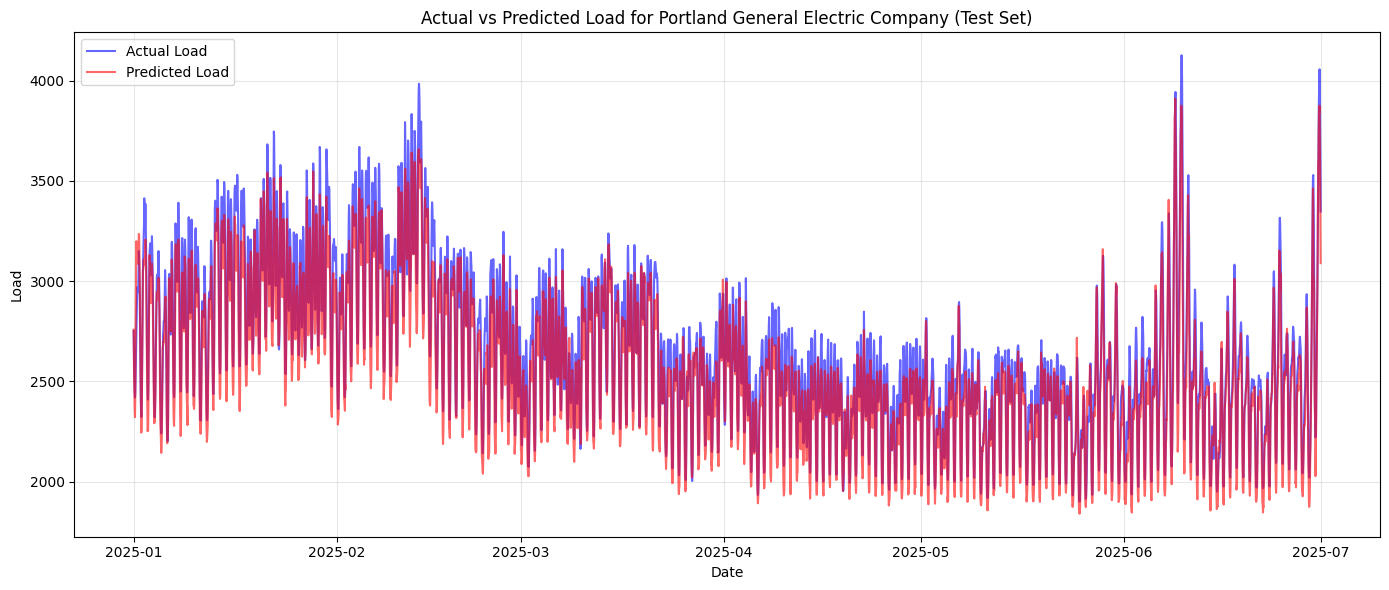

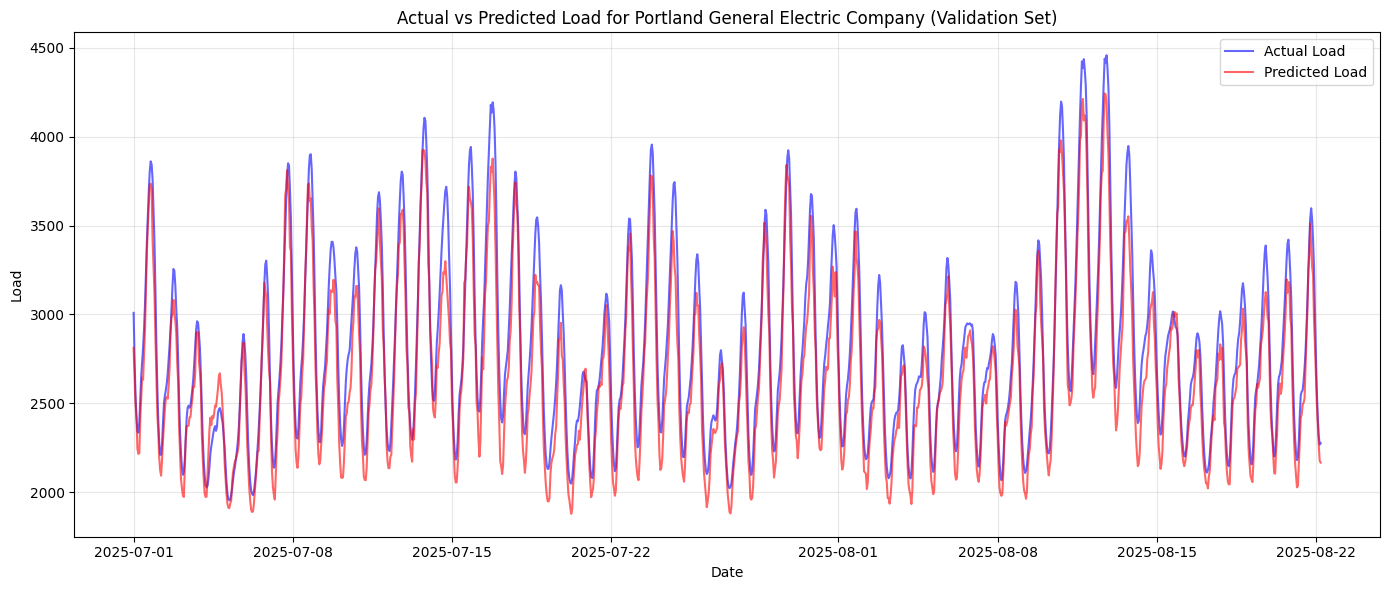


--- Processing City of Tacoma, Department of Public Utilities ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Training data shape: (24993, 213), Test data shape: (4344, 213)
Validation data shape: (1254, 213)
Starting exponential hyperparameter search...
Testing with higher learning_rate: 0.05
  Test R²: 0.9512
  Improved! New best Test R²: 0.9512
Testing with higher learning_rate: 0.1
  Test R²: 0.9596
  Improved! New best Test R²: 0.9596
Testing with higher learning_rate: 0.2
  Test R²: 0.9607
  Improved! New best Test R²: 0.9607
Testing with higher learning_rate: 0.4
  Test R²: 0.9543
Testing with lower learning_rate: 0.1
  Test R²: 0.9596
Testing with higher max_depth: 7
  Test R²: 0.9573
Testing with lower max_depth: 3
  Test R²: 0.9504
Testing with higher n_estimators: 200
  Test R²: 0.9623
  Improved! New best Test R²: 0.9623
Testing with higher n_estimators: 400
  Test R²: 0.9631
  Improved! New best Test R²: 0.9631
Testing with higher n_estimators: 800
  Test 

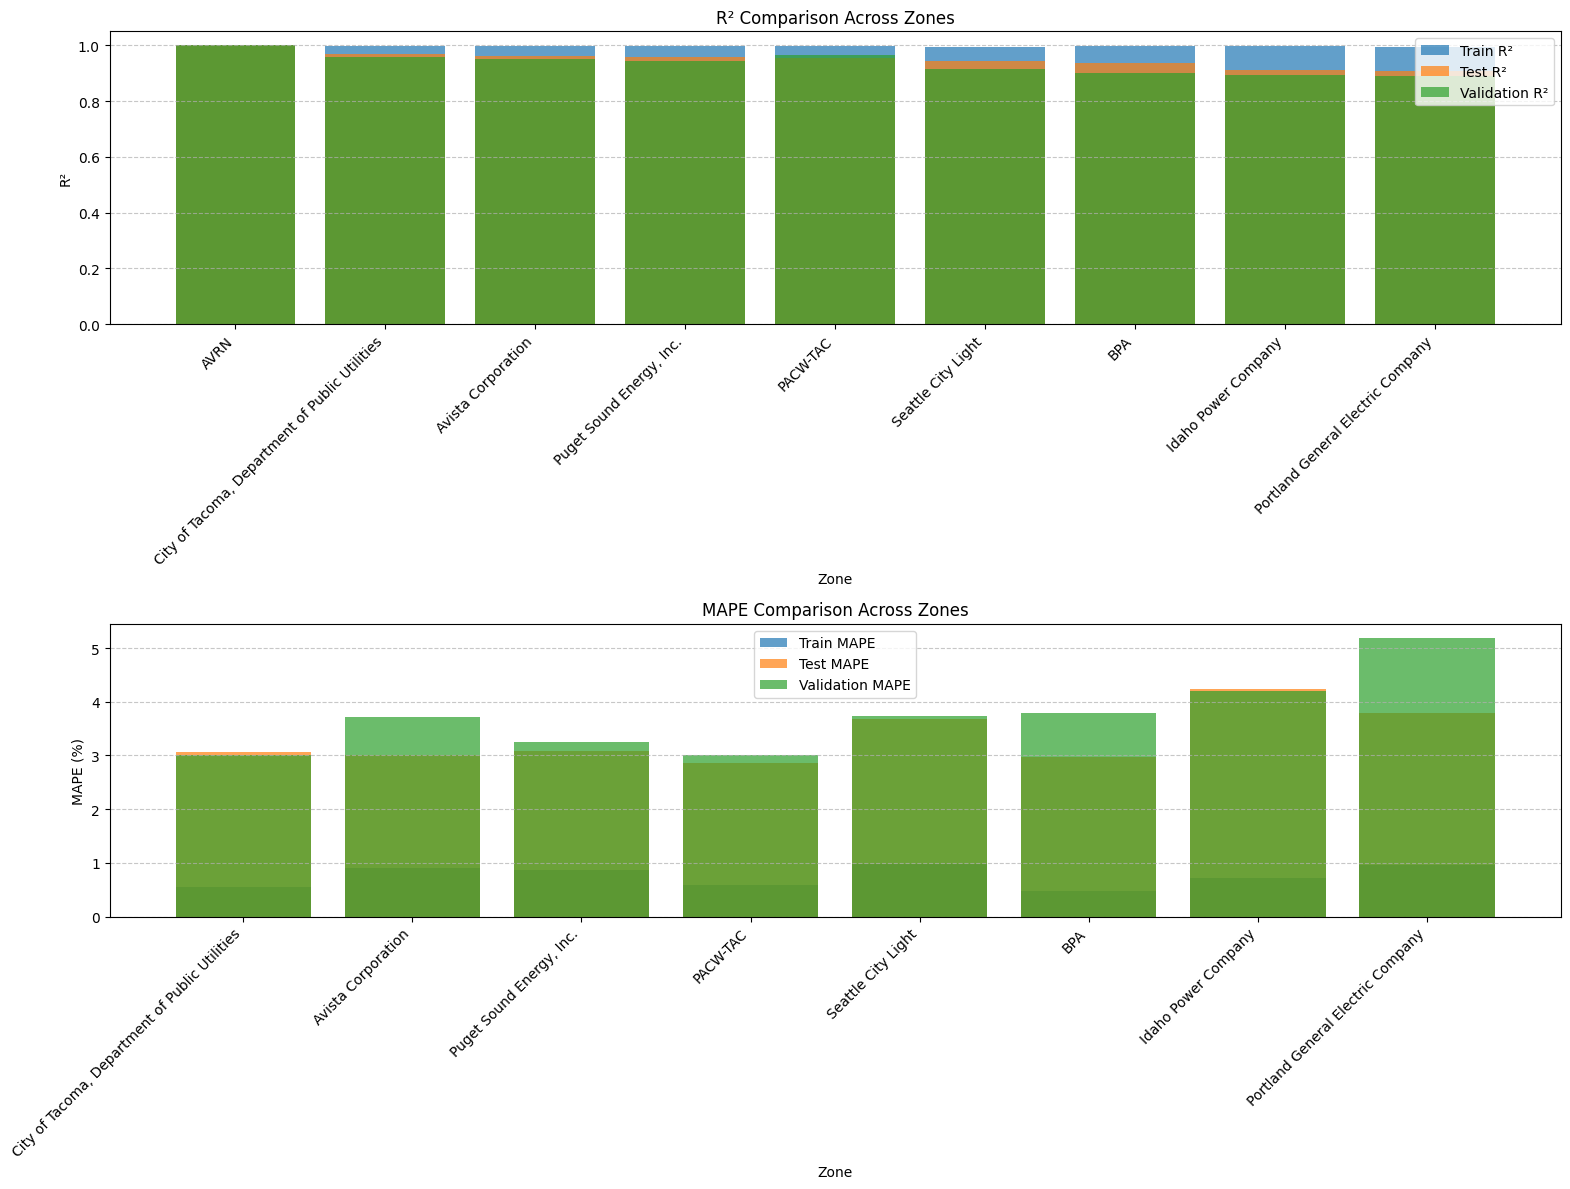

In [6]:
# Get all unique names from DFY
unique_names = DFY['name'].unique()
print(f"Running regression for {len(unique_names)} zones: {unique_names}")

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Name', 'Train R²', 'Test R²', 'Validation R²', 'Train MAPE', 'Test MAPE', 'Validation MAPE', 'Best Parameters'])

# Loop through each name
for name in unique_names:
    print(f"\n--- Processing {name} ---")
    
    # Use the totalload function to calculate the total load
    start_date = pd.to_datetime('2021-10-01')
    end_date = DFY[DFY['name']==name].dropna()['datetime'].max()

    print(f"Data ranges from {start_date} to {end_date}")
    dfY = DFY[(DFY['name']==name) & (DFY['datetime'] >= start_date) & (DFY['datetime'] <= end_date)].dropna().rename(columns={"avgvalue":"load"}).drop(columns=['name'])
    DFX_filtered = DFX[(DFX['datetime'] >= start_date) & (DFX['datetime'] <= end_date)]
    
    # Check if we have enough data
    if len(dfY) < 100:
        print(f"Not enough data for {name}, skipping")
        continue
    
    # Drop nans from dfY['load']
    initial_len = len(dfY)
    dfY = dfY.dropna(subset=['load'])
    dropped_len = initial_len - len(dfY)
    if dropped_len > 0:
        print(f"Dropped {dropped_len} rows with NaN load values")
    
    # Get unique stations and columns to pivot
    stations = DFX_filtered['station_name'].unique()
    columns_to_pivot = DFX_filtered.columns.difference(['datetime', 'station_name'])

    # Create a list to store dataframes for each station
    station_dfs = []

    # For each station, create a dataframe with properly named columns
    for station in stations:
        # Filter data for this station
        station_data = DFX_filtered[DFX_filtered['station_name'] == station]
        
        # Set datetime as index
        station_data = station_data.set_index('datetime')
        
        # Drop the station_name column
        station_data = station_data.drop('station_name', axis=1)
        
        # Rename columns to include station name
        station_data = station_data.rename(columns={col: f"{col}_{station}" for col in station_data.columns})
        
        # Add to list
        station_dfs.append(station_data)

    # Concatenate all station dataframes horizontally
    dfX = pd.concat(station_dfs, axis=1).reset_index()
    
    # Extract date and time components
    dfX['year'] = dfX['datetime'].dt.year
    dfX['month'] = dfX['datetime'].dt.month
    dfX['date'] = dfX['datetime'].dt.day
    dfX['day'] = dfX['datetime'].dt.dayofweek
    dfX['time'] = dfX['datetime'].dt.hour
    
    # Merge X and Y
    df_XY = pd.merge(dfX, dfY, on='datetime')
    
    # Feature Engineering and Selection
    target = 'load'
    exclude_cols = [target, 'Predicted Load', 'set', 'datetime']
    features = [col for col in df_XY.columns if col not in exclude_cols]
    
    X = df_XY[features]
    y = df_XY[target]

    # Define train/test/validation split based on year and month
    train_mask = df_XY['year'] < 2025
    test_mask = (df_XY['year'] == 2025) & (df_XY['month'] <= 6)
    validation_mask = (df_XY['year'] == 2025) & (df_XY['month'] > 6)
    
    # Skip if we don't have both train and test data
    if not train_mask.any() or not test_mask.any():
        print(f"Not enough train/test data for {name}, skipping")
        continue

    # Detrend the target variable based on year
    X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
    y_train_for_trend = y[train_mask]

    trend_model = LinearRegression()
    trend_model.fit(X_year_train, y_train_for_trend)
    
    # Calculate residuals for all data
    X_year = df_XY[['year']].astype(float)
    y_trend = trend_model.predict(X_year)
    y_residuals = y - y_trend

    # Split data
    X_train = X[train_mask]
    X_test = X[test_mask]
    X_validation = X[validation_mask] if validation_mask.any() else None
    
    y_train_residuals = y_residuals[train_mask]
    y_test_residuals = y_residuals[test_mask]
    y_validation_residuals = y_residuals[validation_mask] if validation_mask.any() else None
    
    y_train = y[train_mask]
    y_test = y[test_mask]
    y_validation = y[validation_mask] if validation_mask.any() else None
    
    y_train_trend = y_trend[train_mask]
    y_test_trend = y_trend[test_mask]
    y_validation_trend = y_trend[validation_mask] if validation_mask.any() else None

    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
    if validation_mask.any():
        print(f"Validation data shape: {X_validation.shape}")
    else:
        print("No validation data available")

    # Handle missing values
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
    if X_validation is not None:
        X_validation = X_validation.fillna(X_train.median())

    # Define hyperparameter ranges for exponential search
    param_ranges = {
        'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4],
        'max_depth': [2, 3, 5, 7, 9, 12],
        'n_estimators': [50, 100, 200, 400, 800],
        'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.5]
    }
    
    # Start with median values for each parameter
    current_params = {
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'objective': 'reg:squarederror'
    }
    
    best_test_r2 = -float('inf')
    best_params = current_params.copy()
    best_train_r2 = None
    best_test_mape = None
    best_train_mape = None
    best_validation_r2 = None
    best_validation_mape = None
    best_train_pred = None
    best_test_pred = None
    best_validation_pred = None
    
    print("Starting exponential hyperparameter search...")
    
    # For each parameter, try adjusting to improve performance
    for param_name in ['learning_rate', 'max_depth', 'n_estimators', 'subsample', 'colsample_bytree', 'min_child_weight', 'gamma']:
        param_improved = True
        param_idx = param_ranges[param_name].index(current_params[param_name]) if current_params[param_name] in param_ranges[param_name] else 1
        
        while param_improved:
            param_improved = False
            
            # Try increasing the parameter if not at max
            if param_idx < len(param_ranges[param_name]) - 1:
                higher_param = param_ranges[param_name][param_idx + 1]
                test_params = current_params.copy()
                test_params[param_name] = higher_param
                
                print(f"Testing with higher {param_name}: {higher_param}")
                
                # Train and evaluate with the higher parameter
                model = xgb.XGBRegressor(**test_params)
                model.fit(X_train, y_train_residuals)
                
                # Make predictions
                y_test_residuals_pred = model.predict(X_test)
                y_test_pred = y_test_residuals_pred + y_test_trend
                
                # Calculate test R2
                test_r2 = r2_score(y_test, y_test_pred)
                print(f"  Test R²: {test_r2:.4f}")
                
                # If performance improved, update parameters and continue search
                if test_r2 > best_test_r2:
                    best_test_r2 = test_r2
                    best_params = test_params.copy()
                    current_params = test_params.copy()
                    param_idx += 1
                    param_improved = True
                    print(f"  Improved! New best Test R²: {best_test_r2:.4f}")
            
            # If increasing didn't improve, try decreasing if not at min
            if not param_improved and param_idx > 0:
                lower_param = param_ranges[param_name][param_idx - 1]
                test_params = current_params.copy()
                test_params[param_name] = lower_param
                
                print(f"Testing with lower {param_name}: {lower_param}")
                
                # Train and evaluate with the lower parameter
                model = xgb.XGBRegressor(**test_params)
                model.fit(X_train, y_train_residuals)
                
                # Make predictions
                y_test_residuals_pred = model.predict(X_test)
                y_test_pred = y_test_residuals_pred + y_test_trend
                
                # Calculate test R2
                test_r2 = r2_score(y_test, y_test_pred)
                print(f"  Test R²: {test_r2:.4f}")
                
                # If performance improved, update parameters and continue search
                if test_r2 > best_test_r2:
                    best_test_r2 = test_r2
                    best_params = test_params.copy()
                    current_params = test_params.copy()
                    param_idx -= 1
                    param_improved = True
                    print(f"  Improved! New best Test R²: {best_test_r2:.4f}")
    
    # Final evaluation with the best parameters
    print("\nTraining final model with best parameters:")
    print(best_params)
    
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_train, y_train_residuals)
    
    # Make predictions on all data sets
    y_train_residuals_pred = final_model.predict(X_train)
    y_test_residuals_pred = final_model.predict(X_test)
    
    # Add trend back
    y_train_pred = y_train_residuals_pred + y_train_trend
    y_test_pred = y_test_residuals_pred + y_test_trend
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    print(f"R-squared on training data: {train_r2:.4f}")
    print(f"R-squared on test data: {test_r2:.4f}")
    print(f"MAPE on training data: {train_mape:.2f}%")
    print(f"MAPE on test data: {test_mape:.2f}%")
    
    # Evaluate on validation set if available
    validation_r2 = None
    validation_mape = None
    validation_pred = None
    
    if validation_mask.any():
        y_validation_residuals_pred = final_model.predict(X_validation)
        y_validation_pred = y_validation_residuals_pred + y_validation_trend
        validation_r2 = r2_score(y_validation, y_validation_pred)
        validation_mape = np.mean(np.abs((y_validation - y_validation_pred) / y_validation)) * 100
        validation_pred = y_validation_pred
        print(f"R-squared on validation data: {validation_r2:.4f}")
        print(f"MAPE on validation data: {validation_mape:.2f}%")
    
    # Add results to DataFrame
    results_df = results_df._append({
        'Name': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Validation R²': validation_r2,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
        'Validation MAPE': validation_mape,
        'Best Parameters': str(best_params)
    }, ignore_index=True)
    
    # Optional: Plot actual vs predicted for the best model
    if name == 'Portland General Electric Company':
        plt.figure(figsize=(14, 6))
        
        # Create a date range for the test data
        test_dates = df_XY.loc[test_mask, 'datetime']
        
        # Plot the test data predictions
        plt.plot(test_dates, y_test, 'b-', alpha=0.6, label='Actual Load')
        plt.plot(test_dates, y_test_pred, 'r-', alpha=0.6, label='Predicted Load')
        
        # Add labels and title
        plt.title(f'Actual vs Predicted Load for {name} (Test Set)')
        plt.xlabel('Date')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # If validation data exists, plot it too
        if validation_mask.any():
            plt.figure(figsize=(14, 6))
            validation_dates = df_XY.loc[validation_mask, 'datetime']
            plt.plot(validation_dates, y_validation, 'b-', alpha=0.6, label='Actual Load')
            plt.plot(validation_dates, validation_pred, 'r-', alpha=0.6, label='Predicted Load')
            plt.title(f'Actual vs Predicted Load for {name} (Validation Set)')
            plt.xlabel('Date')
            plt.ylabel('Load')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

# Sort results by Test R² (descending)
results_df = results_df.sort_values('Test R²', ascending=False)

# Display the results table
print("\n--- REGRESSION RESULTS FOR ALL ZONES ---")
print(results_df.to_string(index=False))

# Plot the results
plt.figure(figsize=(16, 12))

# Plot Train vs Test vs Validation R²
plt.subplot(2, 1, 1)
plt.bar(results_df['Name'], results_df['Train R²'], alpha=0.7, label='Train R²')
plt.bar(results_df['Name'], results_df['Test R²'], alpha=0.7, label='Test R²')
if 'Validation R²' in results_df.columns and not results_df['Validation R²'].isna().all():
    plt.bar(results_df['Name'], results_df['Validation R²'], alpha=0.7, label='Validation R²')
plt.xlabel('Zone')
plt.ylabel('R²')
plt.title('R² Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Train vs Test vs Validation MAPE
plt.subplot(2, 1, 2)
plt.bar(results_df['Name'], results_df['Train MAPE'], alpha=0.7, label='Train MAPE')
plt.bar(results_df['Name'], results_df['Test MAPE'], alpha=0.7, label='Test MAPE')
if 'Validation MAPE' in results_df.columns and not results_df['Validation MAPE'].isna().all():
    plt.bar(results_df['Name'], results_df['Validation MAPE'], alpha=0.7, label='Validation MAPE')
plt.xlabel('Zone')
plt.ylabel('MAPE (%)')
plt.title('MAPE Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
#store the best hyperparameters for each zone in a csv file
results_df.to_csv("NWPPZonalload_hyperparameters_with_validation.csv", index=False)

Running regression for 9 zones: ['Puget Sound Energy, Inc.' 'BPA' 'Avista Corporation'
 'Seattle City Light' 'PACW-TAC' 'Idaho Power Company' 'AVRN'
 'Portland General Electric Company'
 'City of Tacoma, Department of Public Utilities']

--- Processing Puget Sound Energy, Inc. ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00


C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for Puget Sound Energy, Inc.:
                  Feature  Importance                     Zone
           windChill_NWPP    0.256374 Puget Sound Energy, Inc.
        windChill_Spokane    0.145024 Puget Sound Energy, Inc.
                     time    0.087812 Puget Sound Energy, Inc.
       windChill_Portland    0.079012 Puget Sound Energy, Inc.
           heatIndex_NWPP    0.060939 Puget Sound Energy, Inc.
      windChill_Vancouver    0.043229 Puget Sound Energy, Inc.
      heatIndex_Vancouver    0.042508 Puget Sound Energy, Inc.
      temperature_Seattle    0.029835 Puget Sound Energy, Inc.
        heatIndex_Seattle    0.028684 Puget Sound Energy, Inc.
        heatIndex_Spokane    0.028368 Puget Sound Energy, Inc.
      temperature_Spokane    0.025755 Puget Sound Energy, Inc.
        windChill_Seattle    0.016706 Puget Sound Energy, Inc.
    temperature_Vancouver    0.013351 Puget Sound Energy, Inc.
                      day    0.013015 Puget Sound Energy, Inc.
         

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for BPA:
                      Feature  Importance Zone
           windChill_Portland    0.246546  BPA
               windChill_NWPP    0.180805  BPA
          temperature_Spokane    0.095088  BPA
                         time    0.084198  BPA
               heatIndex_NWPP    0.071270  BPA
            temperature_Boise    0.048592  BPA
            heatIndex_Spokane    0.028897  BPA
             temperature_NWPP    0.027570  BPA
            windChill_Spokane    0.025820  BPA
                          day    0.016913  BPA
            heatIndex_Seattle    0.015225  BPA
           heatIndex_Portland    0.011510  BPA
         temperature_Portland    0.011246  BPA
           temperature_Yakima    0.010053  BPA
                         year    0.010014  BPA
                        month    0.009662  BPA
      temperature_min_Spokane    0.004974  BPA
            windChill_Seattle    0.004614  BPA
             heatIndex_Yakima    0.003694  BPA
            heatIndex_Medford    0.

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for Avista Corporation:
                       Feature  Importance               Zone
           temperature_Spokane    0.219372 Avista Corporation
                windChill_NWPP    0.144066 Avista Corporation
             heatIndex_Spokane    0.121813 Avista Corporation
                          time    0.079795 Avista Corporation
               heatIndex_Boise    0.057156 Avista Corporation
             windChill_Spokane    0.047311 Avista Corporation
            windChill_Portland    0.038172 Avista Corporation
      windChill_Salt Lake City    0.027457 Avista Corporation
              heatIndex_Yakima    0.021199 Avista Corporation
                           day    0.016588 Avista Corporation
           heatIndex_Pendleton    0.015533 Avista Corporation
             cloudCover_Eugene    0.014208 Avista Corporation
      heatIndex_Salt Lake City    0.014018 Avista Corporation
                         month    0.013409 Avista Corporation
               windChill_Boise

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for Seattle City Light:
                       Feature  Importance               Zone
                windChill_NWPP    0.244598 Seattle City Light
              temperature_NWPP    0.090059 Seattle City Light
                 dewpoint_NWPP    0.077651 Seattle City Light
                          time    0.074954 Seattle City Light
     temperature_Klamath Falls    0.058436 Seattle City Light
             windChill_Spokane    0.052059 Seattle City Light
           windChill_Vancouver    0.048904 Seattle City Light
                heatIndex_NWPP    0.043068 Seattle City Light
           temperature_Seattle    0.034809 Seattle City Light
         temperature_Pendleton    0.025839 Seattle City Light
            temperature_Eugene    0.021495 Seattle City Light
            dewpoint_Vancouver    0.018236 Seattle City Light
                           day    0.016814 Seattle City Light
             cloudCover_Eugene    0.013153 Seattle City Light
            temperature_Yakima

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for PACW-TAC:
                  Feature  Importance     Zone
           heatIndex_NWPP    0.176414 PACW-TAC
       windChill_Portland    0.106925 PACW-TAC
          heatIndex_Boise    0.101388 PACW-TAC
                     time    0.085070 PACW-TAC
           windChill_NWPP    0.079489 PACW-TAC
      temperature_Spokane    0.060195 PACW-TAC
        heatIndex_Medford    0.043185 PACW-TAC
      temperature_Medford    0.032198 PACW-TAC
                      day    0.032047 PACW-TAC
         heatIndex_Yakima    0.022373 PACW-TAC
        windChill_Spokane    0.021753 PACW-TAC
        temperature_Boise    0.015206 PACW-TAC
       temperature_Yakima    0.014849 PACW-TAC
        windChill_Medford    0.014455 PACW-TAC
            dewpoint_NWPP    0.013096 PACW-TAC
        cloudCover_Eugene    0.010282 PACW-TAC
        dewpoint_Portland    0.010102 PACW-TAC
          windChill_Boise    0.010089 PACW-TAC
                     year    0.008120 PACW-TAC
                    month    0

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for Idaho Power Company:
                       Feature  Importance                Zone
               heatIndex_Boise    0.295101 Idaho Power Company
             temperature_Boise    0.273254 Idaho Power Company
      heatIndex_Salt Lake City    0.083234 Idaho Power Company
    temperature_Salt Lake City    0.046574 Idaho Power Company
               windChill_Boise    0.028463 Idaho Power Company
                         month    0.024695 Idaho Power Company
         temperature_Vancouver    0.023506 Idaho Power Company
                          time    0.021653 Idaho Power Company
           heatIndex_Vancouver    0.014407 Idaho Power Company
                heatIndex_NWPP    0.013290 Idaho Power Company
             heatIndex_Spokane    0.011132 Idaho Power Company
                heatIndex_Reno    0.010829 Idaho Power Company
                           day    0.009601 Idaho Power Company
             windChill_Spokane    0.009059 Idaho Power Company
             d

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for AVRN:
                     Feature  Importance Zone
         cloudCover_Billings         0.0 AVRN
           dewpoint_Billings         0.0 AVRN
          heatIndex_Billings         0.0 AVRN
   relativeHumidity_Billings         0.0 AVRN
        temperature_Billings         0.0 AVRN
    temperature_avg_Billings         0.0 AVRN
    temperature_max_Billings         0.0 AVRN
    temperature_min_Billings         0.0 AVRN
       weighted_cdd_Billings         0.0 AVRN
       weighted_hdd_Billings         0.0 AVRN
          windChill_Billings         0.0 AVRN
      windDirection_Billings         0.0 AVRN
          windSpeed_Billings         0.0 AVRN
            cloudCover_Boise         0.0 AVRN
              dewpoint_Boise         0.0 AVRN
             heatIndex_Boise         0.0 AVRN
      relativeHumidity_Boise         0.0 AVRN
           temperature_Boise         0.0 AVRN
       temperature_avg_Boise         0.0 AVRN
       temperature_max_Boise         0.0 AVRN
       t

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


Top 53 features for Portland General Electric Company:
                       Feature  Importance                              Zone
            windChill_Portland    0.164316 Portland General Electric Company
                windChill_NWPP    0.118866 Portland General Electric Company
            heatIndex_Portland    0.104236 Portland General Electric Company
                heatIndex_NWPP    0.094496 Portland General Electric Company
                          time    0.075715 Portland General Electric Company
              temperature_NWPP    0.069196 Portland General Electric Company
          temperature_Portland    0.065511 Portland General Electric Company
           temperature_Spokane    0.024109 Portland General Electric Company
             windChill_Spokane    0.020895 Portland General Electric Company
                           day    0.016981 Portland General Electric Company
            temperature_Yakima    0.013381 Portland General Electric Company
             dewpoint

C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\4278490063.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features['Zone'] = name


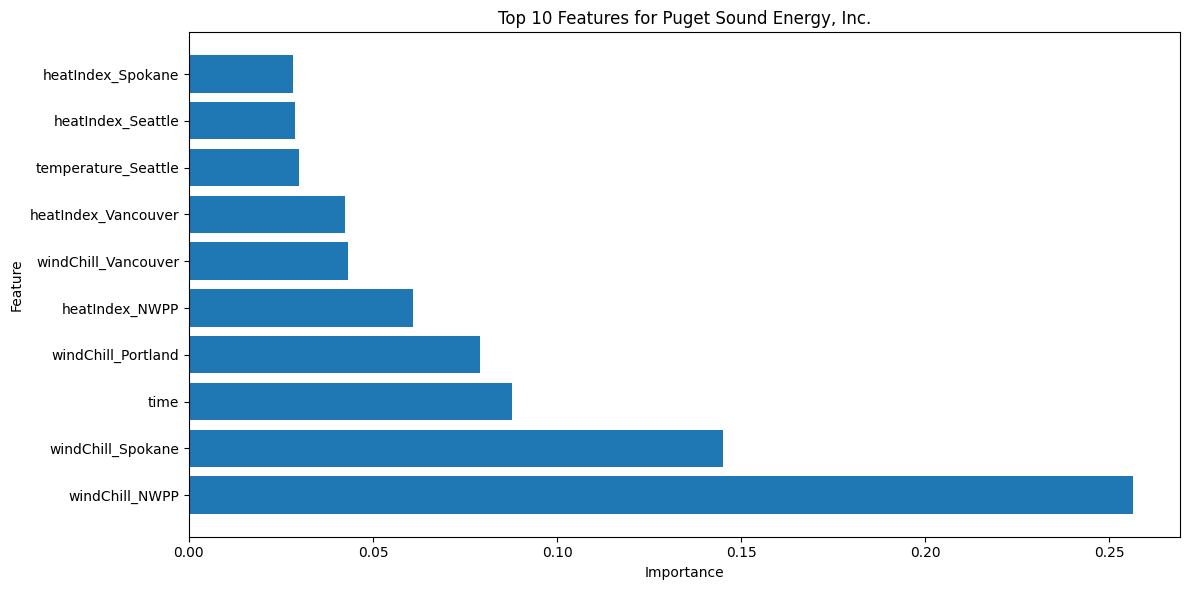

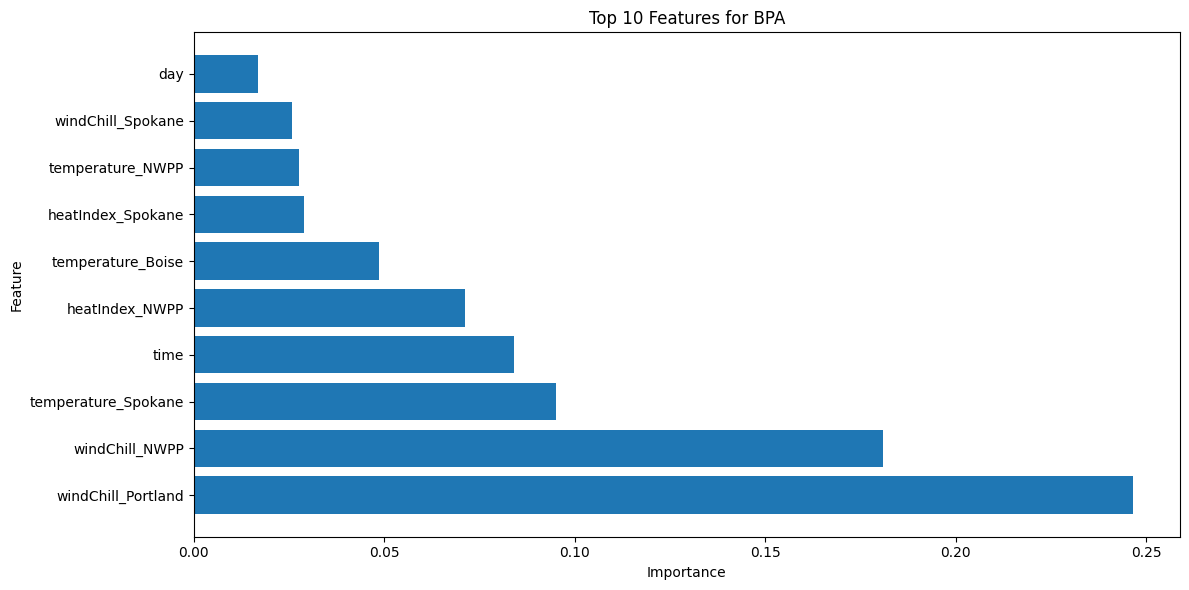

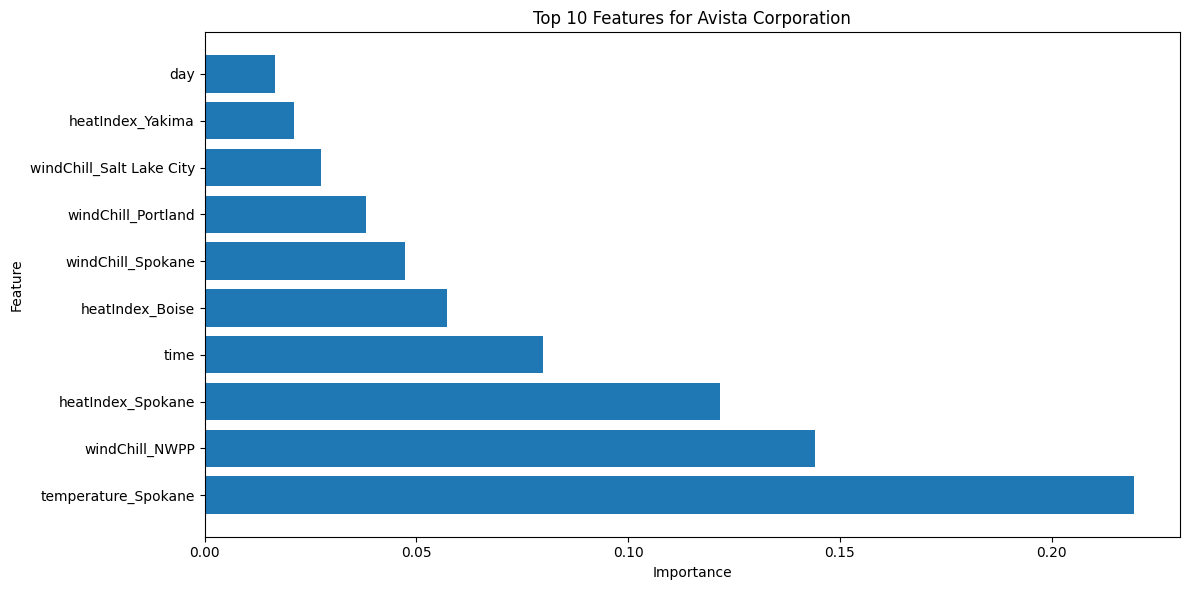

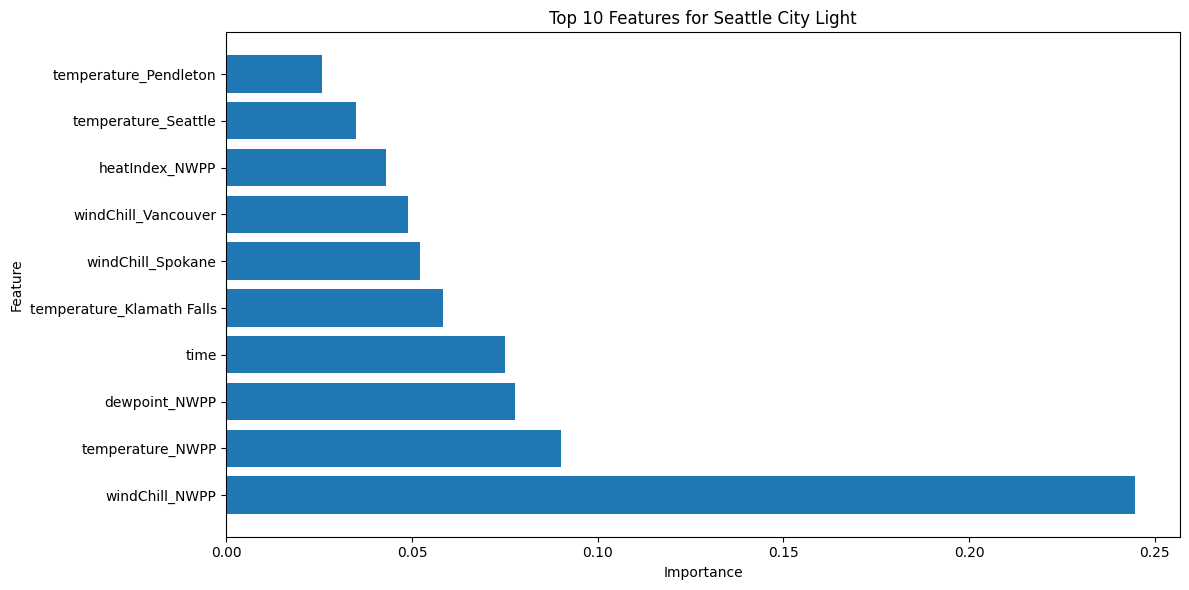

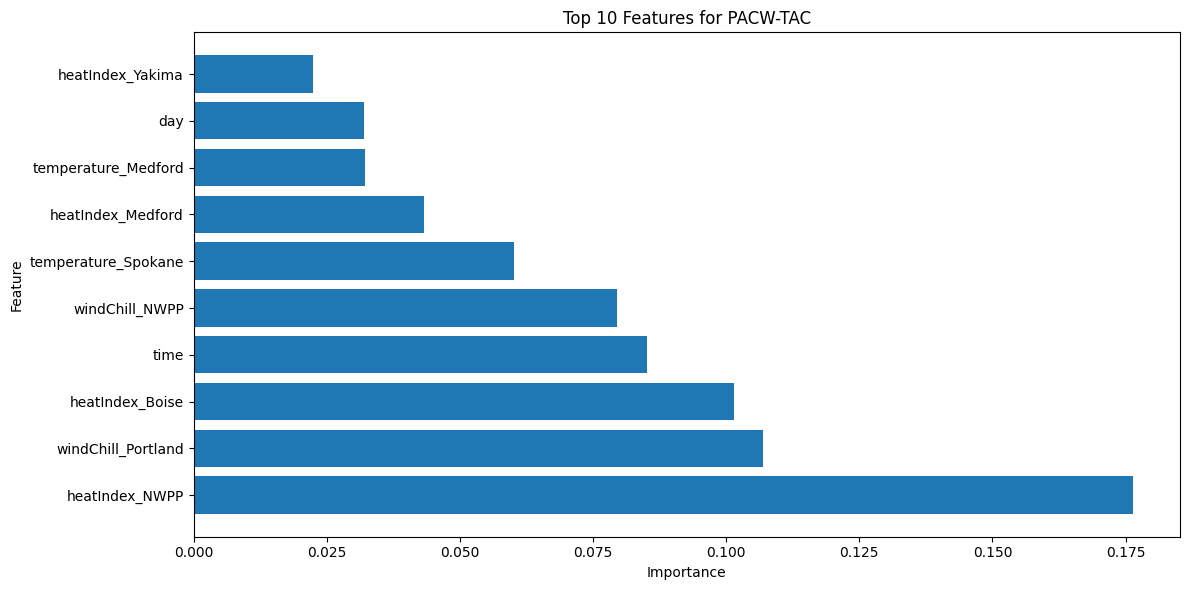

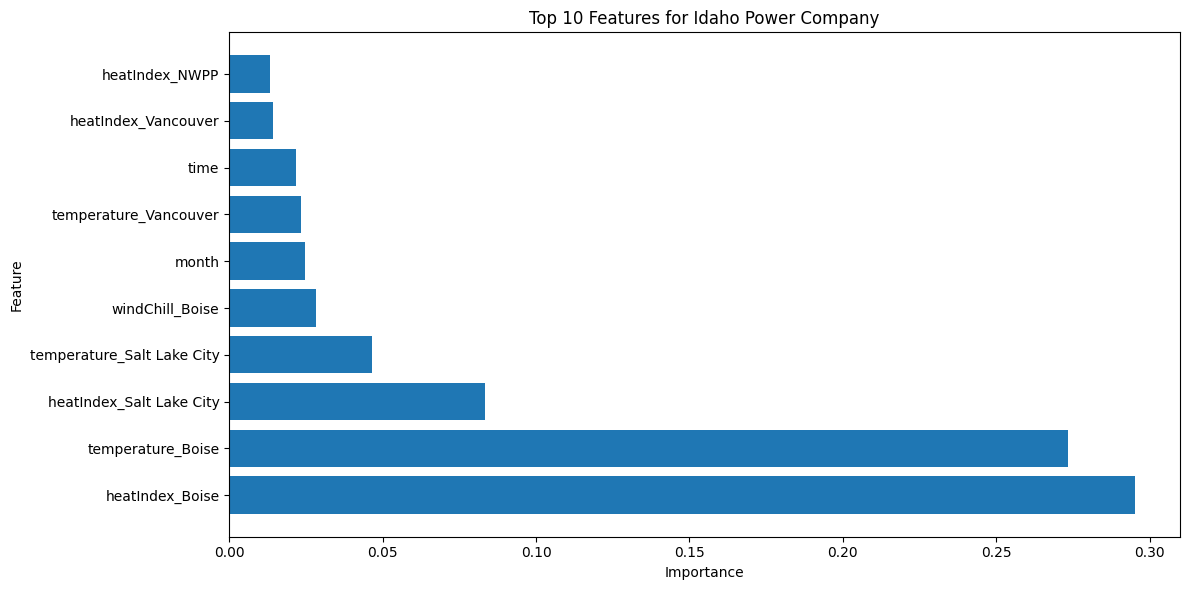

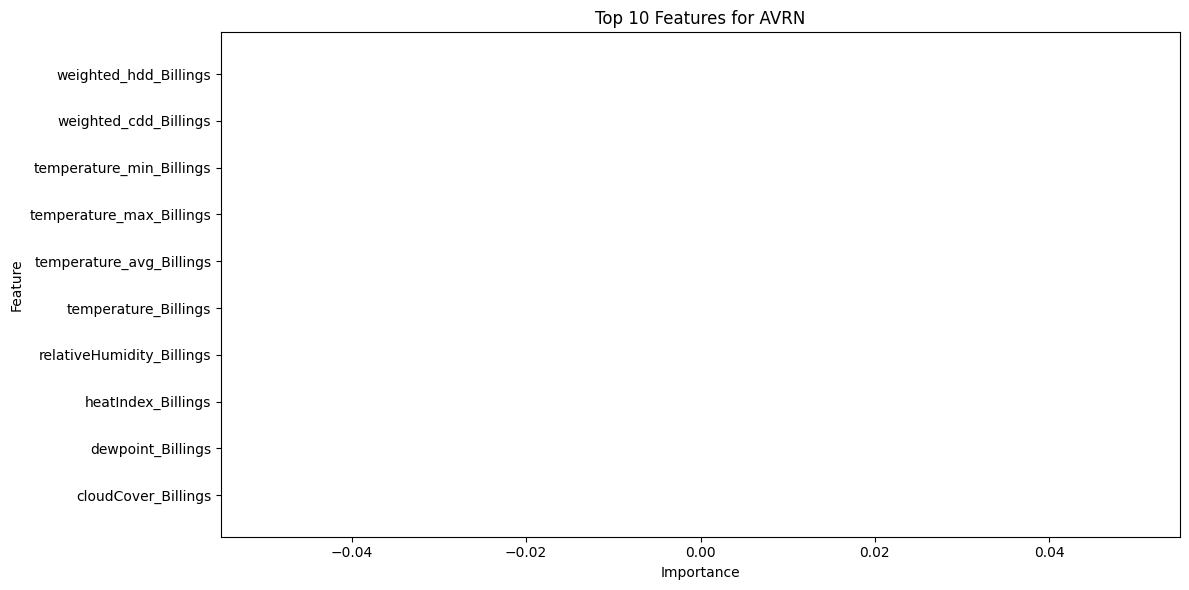

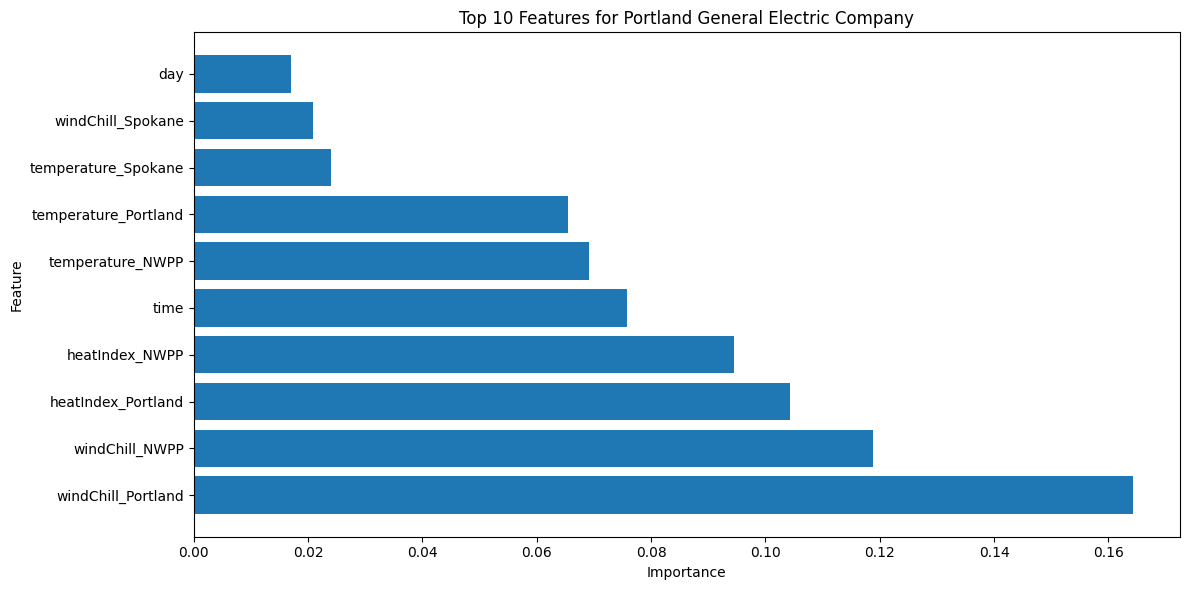

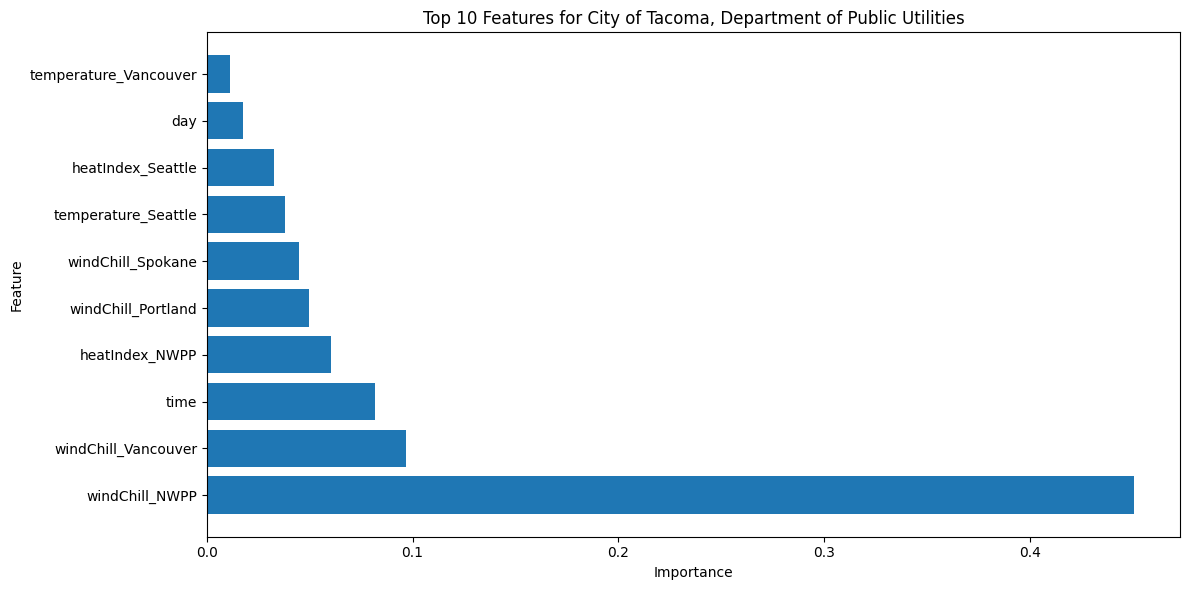

In [6]:
# Load the best hyperparameters from the saved CSV
best_params_df = pd.read_csv("NWPPZonalload_hyperparameters_with_validation.csv")

# Get all unique names from DFY
unique_names = DFY['name'].unique()
print(f"Running regression for {len(unique_names)} zones: {unique_names}")

# Create a DataFrame to store feature importance results
feature_importance_df = pd.DataFrame()

# Loop through each name
for name in unique_names:
    print(f"\n--- Processing {name} ---")
    
    # Get best parameters for this zone
    zone_params = best_params_df[best_params_df['Name'] == name]
    if zone_params.empty:
        print(f"No hyperparameters found for {name}, skipping")
        continue
    
    # Parse the best parameters string
    best_params_str = zone_params['Best Parameters'].values[0]
    # Convert string representation of dict to actual dict
    import ast
    best_params = ast.literal_eval(best_params_str)
    
    # Use the totalload function to calculate the total load
    start_date = pd.to_datetime('2021-10-01')
    end_date = DFY[DFY['name']==name].dropna()['datetime'].max()

    print(f"Data ranges from {start_date} to {end_date}")
    dfY = DFY[(DFY['name']==name) & (DFY['datetime'] >= start_date) & (DFY['datetime'] <= end_date)].dropna().rename(columns={"avgvalue":"load"}).drop(columns=['name'])
    DFX_filtered = DFX[(DFX['datetime'] >= start_date) & (DFX['datetime'] <= end_date)]
    
    # Check if we have enough data
    if len(dfY) < 100:
        print(f"Not enough data for {name}, skipping")
        continue
    
    # Drop nans from dfY['load']
    initial_len = len(dfY)
    dfY = dfY.dropna(subset=['load'])
    dropped_len = initial_len - len(dfY)
    if dropped_len > 0:
        print(f"Dropped {dropped_len} rows with NaN load values")
    
    # Get unique stations and columns to pivot (reuse the existing code)
    stations = DFX_filtered['station_name'].unique()
    columns_to_pivot = DFX_filtered.columns.difference(['datetime', 'station_name'])

    # Create a list to store dataframes for each station
    station_dfs = []

    # For each station, create a dataframe with properly named columns
    for station in stations:
        # Filter data for this station
        station_data = DFX_filtered[DFX_filtered['station_name'] == station]
        
        # Set datetime as index
        station_data = station_data.set_index('datetime')
        
        # Drop the station_name column
        station_data = station_data.drop('station_name', axis=1)
        
        # Rename columns to include station name
        station_data = station_data.rename(columns={col: f"{col}_{station}" for col in station_data.columns})
        
        # Add to list
        station_dfs.append(station_data)

    # Concatenate all station dataframes horizontally
    dfX = pd.concat(station_dfs, axis=1).reset_index()
    
    # Extract date and time components
    dfX['year'] = dfX['datetime'].dt.year
    dfX['month'] = dfX['datetime'].dt.month
    dfX['date'] = dfX['datetime'].dt.day
    dfX['day'] = dfX['datetime'].dt.dayofweek
    dfX['time'] = dfX['datetime'].dt.hour
    
    # Merge X and Y
    df_XY = pd.merge(dfX, dfY, on='datetime')
    
    # Feature Engineering and Selection
    target = 'load'
    exclude_cols = [target, 'Predicted Load', 'set', 'datetime']
    features = [col for col in df_XY.columns if col not in exclude_cols]
    
    X = df_XY[features]
    y = df_XY[target]

    # Define train/test/validation split based on year and month
    train_mask = df_XY['year'] < 2025
    test_mask = (df_XY['year'] == 2025) & (df_XY['month'] <= 6)
    validation_mask = (df_XY['year'] == 2025) & (df_XY['month'] > 6)
    
    # Skip if we don't have both train and test data
    if not train_mask.any() or not test_mask.any():
        print(f"Not enough train/test data for {name}, skipping")
        continue

    # Detrend the target variable based on year
    X_year_train = df_XY.loc[train_mask, ['year']].astype(float)
    y_train_for_trend = y[train_mask]

    trend_model = LinearRegression()
    trend_model.fit(X_year_train, y_train_for_trend)
    
    # Calculate residuals for all data
    X_year = df_XY[['year']].astype(float)
    y_trend = trend_model.predict(X_year)
    y_residuals = y - y_trend

    # Split data
    X_train = X[train_mask]
    X_test = X[test_mask]
    X_validation = X[validation_mask] if validation_mask.any() else None
    
    y_train_residuals = y_residuals[train_mask]
    y_test_residuals = y_residuals[test_mask]
    
    # Handle missing values
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())
    if X_validation is not None:
        X_validation = X_validation.fillna(X_train.median())

    # Train final model with best parameters
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_train, y_train_residuals)
    
    # Get feature importance
    feature_importance = final_model.feature_importances_
    
    # Create a DataFrame with feature names and their importance scores
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importance
    })
    
    # Sort by importance in descending order
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Calculate the 25% threshold for feature selection
    top_features_count = int(len(importance_df) * 0.25)
    top_features = importance_df.head(top_features_count)
    
    # Add zone name to the DataFrame
    top_features['Zone'] = name
    
    # Append to the main feature importance DataFrame
    feature_importance_df = pd.concat([feature_importance_df, top_features])
    
    print(f"Top {top_features_count} features for {name}:")
    print(top_features.to_string(index=False))

# Save all feature importance results
feature_importance_df.to_csv("all_zones_top_features.csv", index=False)

# Plot the top 10 features for each zone
for name in unique_names:
    zone_features = feature_importance_df[feature_importance_df['Zone'] == name]
    if not zone_features.empty:
        plt.figure(figsize=(12, 6))
        zone_top10 = zone_features.head(10)
        plt.barh(zone_top10['Feature'], zone_top10['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 10 Features for {name}')
        plt.tight_layout()
        plt.show()


--- Processing Puget Sound Energy, Inc. with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9940, Test R²: 0.9705
Train MAPE: 1.18%, Test MAPE: 2.70%
Validation R²: 0.9685, Validation MAPE: 2.20%


C:\Users\kumar\AppData\Local\Temp\ipykernel_19120\1090839645.py:211: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  poly_results_df = poly_results_df._append({


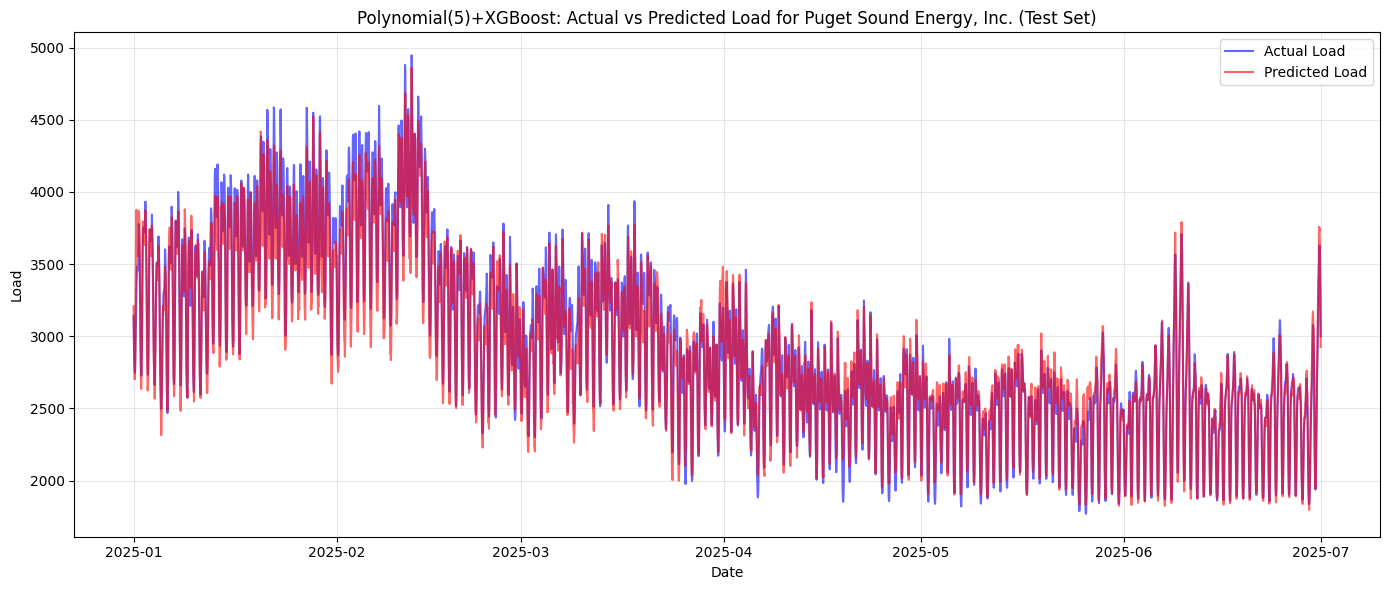


--- Processing BPA with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 07:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9948, Test R²: 0.9197
Train MAPE: 0.86%, Test MAPE: 3.28%
Validation R²: 0.8344, Validation MAPE: 4.63%


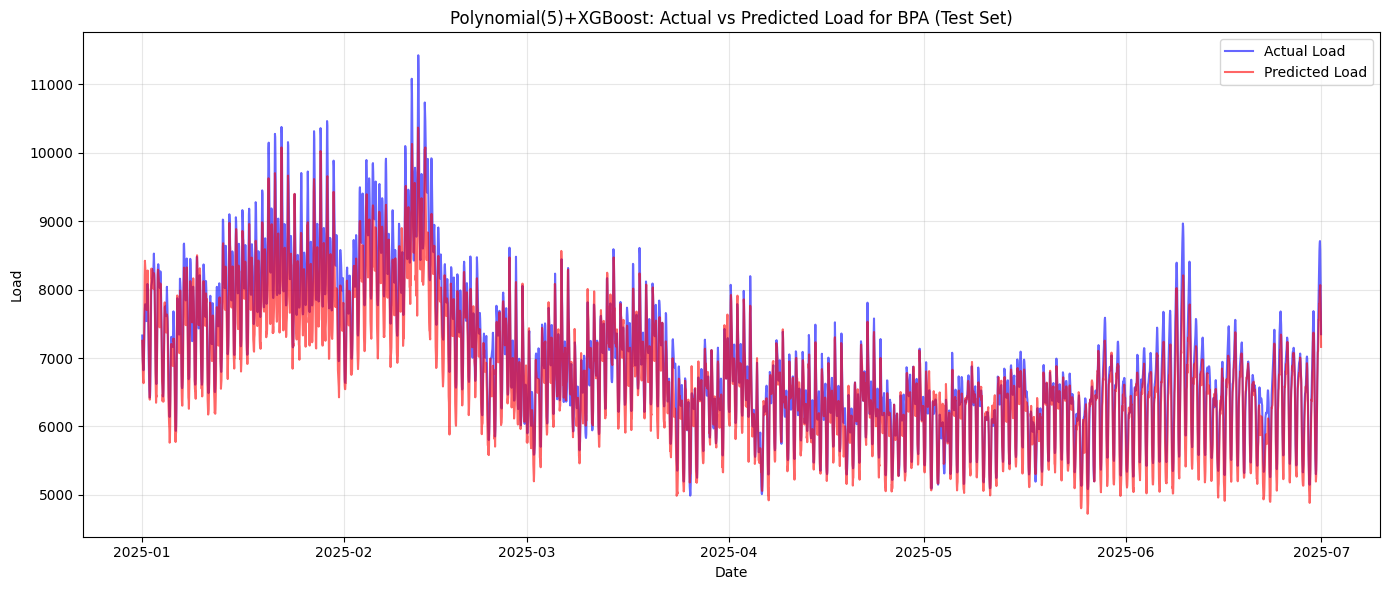


--- Processing Avista Corporation with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9927, Test R²: 0.9560
Train MAPE: 1.34%, Test MAPE: 3.10%
Validation R²: 0.9284, Validation MAPE: 4.15%


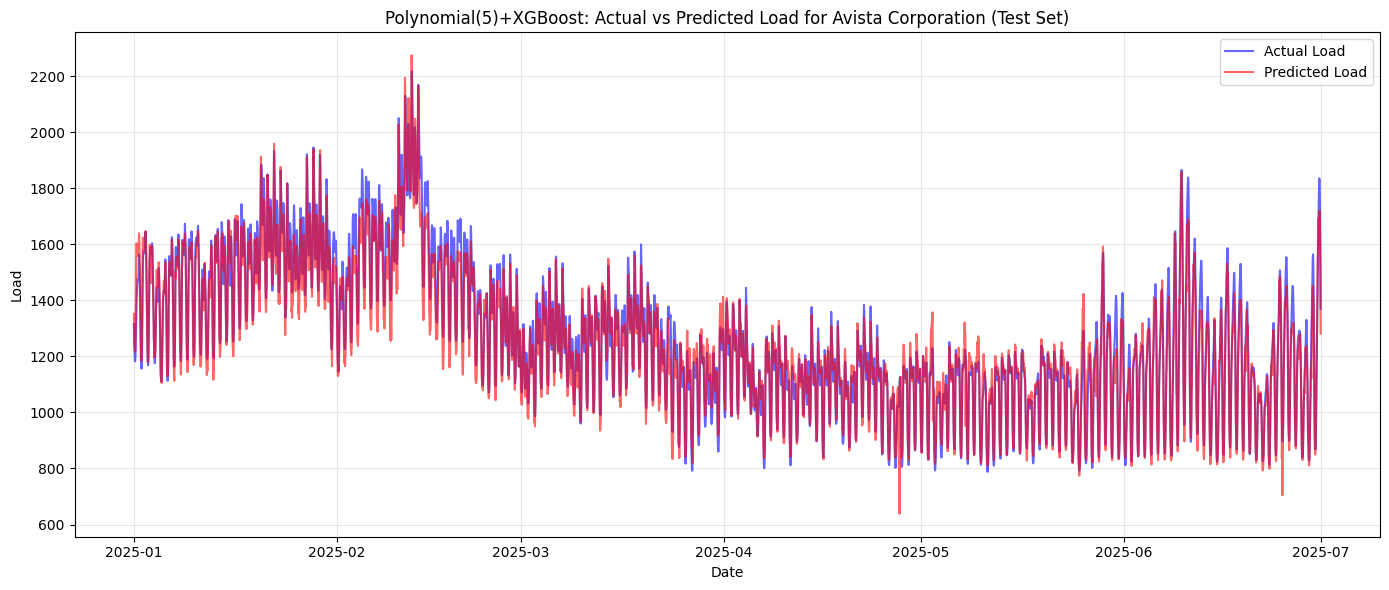


--- Processing Seattle City Light with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9881, Test R²: 0.9558
Train MAPE: 1.55%, Test MAPE: 3.10%
Validation R²: 0.9524, Validation MAPE: 2.47%


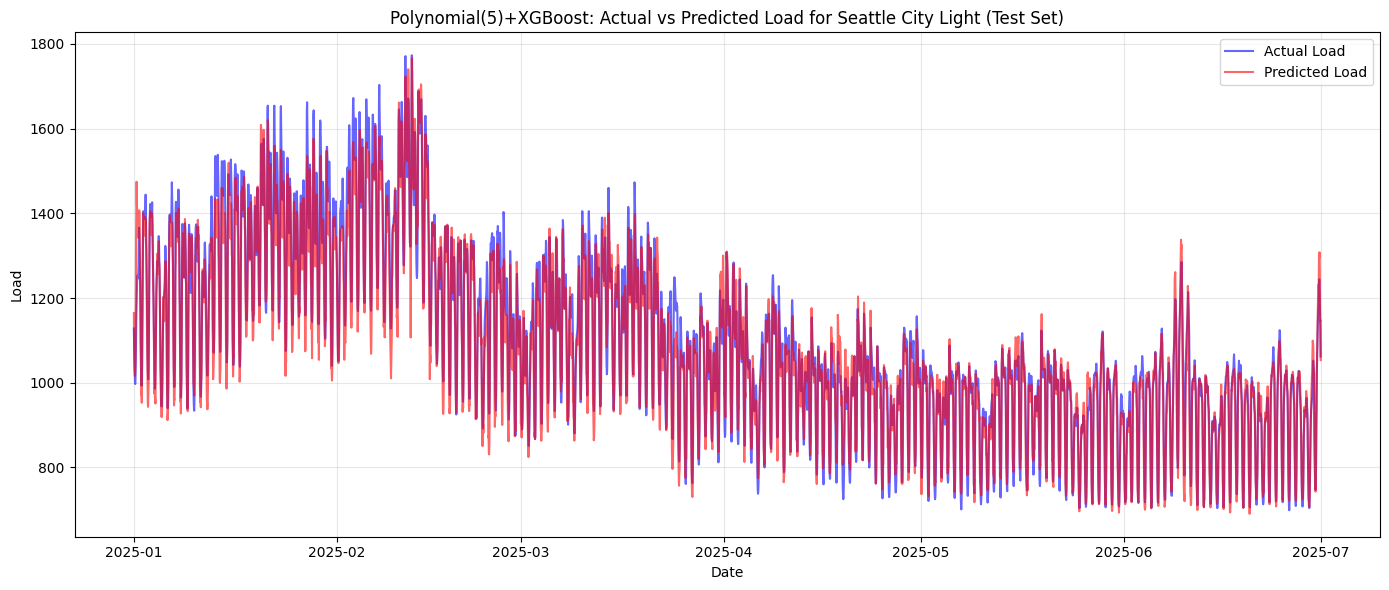


--- Processing PACW-TAC with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9946, Test R²: 0.9514
Train MAPE: 0.99%, Test MAPE: 2.84%
Validation R²: 0.9669, Validation MAPE: 2.59%


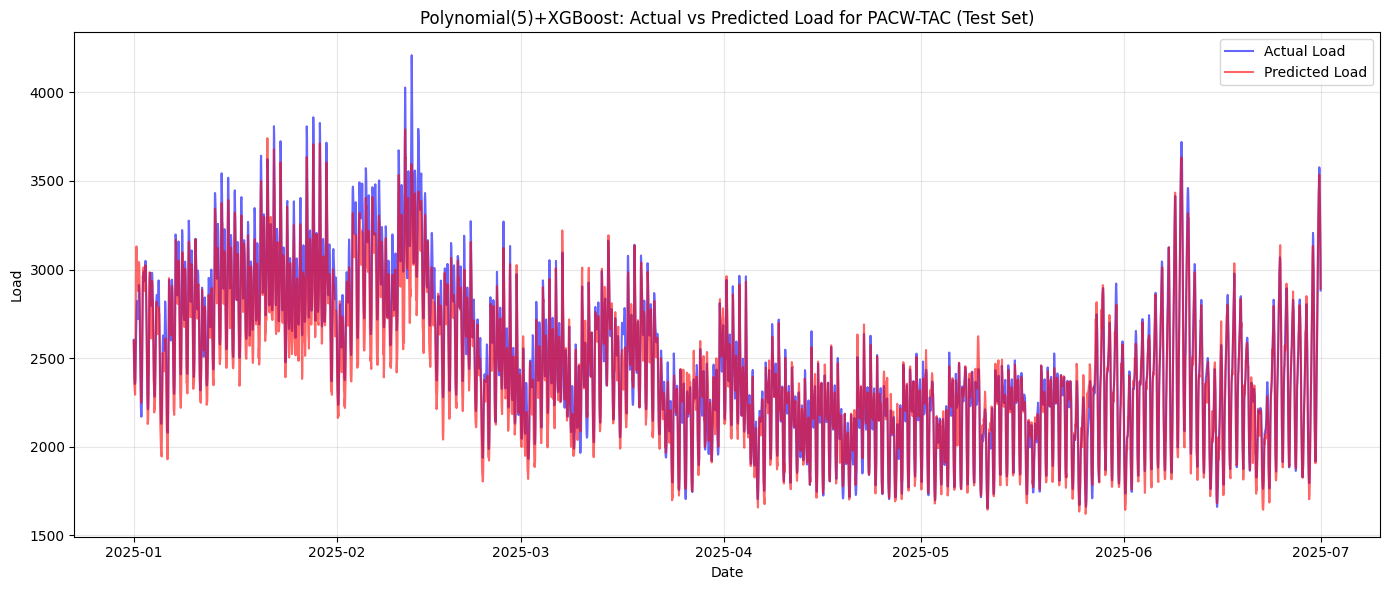


--- Processing Idaho Power Company with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9925, Test R²: 0.8447
Train MAPE: 1.46%, Test MAPE: 5.49%
Validation R²: 0.7956, Validation MAPE: 5.58%


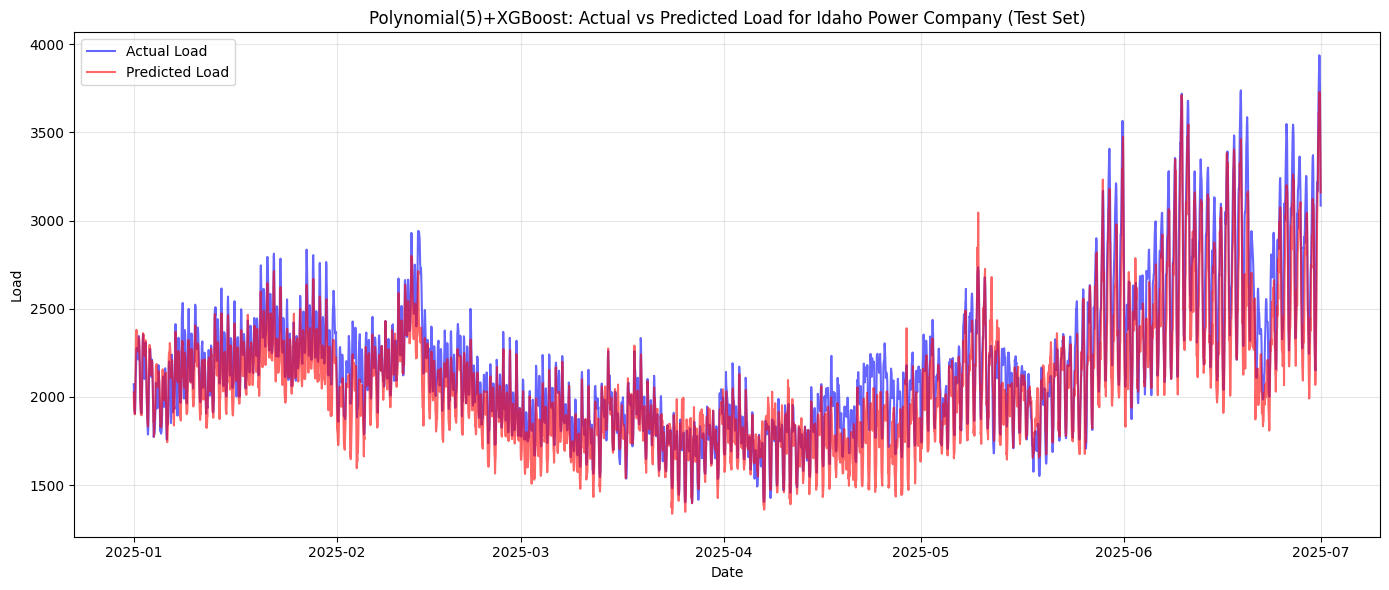


--- Processing AVRN with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 1.0000, Test R²: 1.0000
Train MAPE: nan%, Test MAPE: nan%
Validation R²: 1.0000, Validation MAPE: nan%


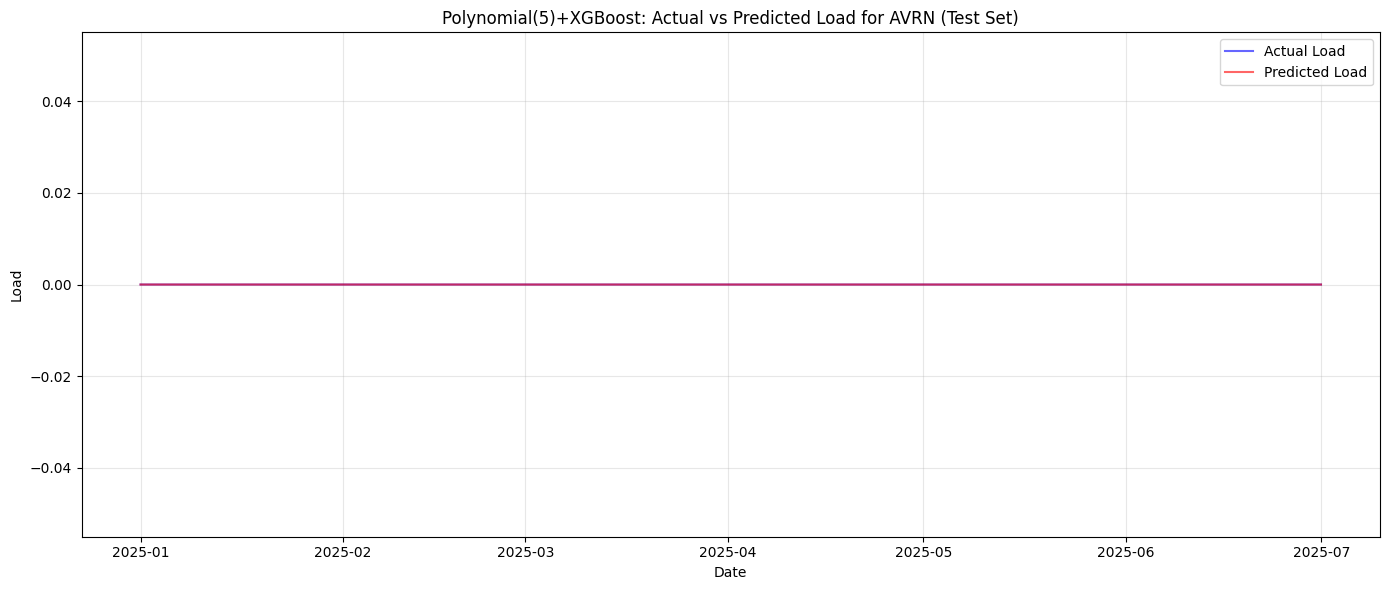


--- Processing Portland General Electric Company with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9844, Test R²: 0.8283
Train MAPE: 1.58%, Test MAPE: 5.51%
Validation R²: 0.8071, Validation MAPE: 7.01%


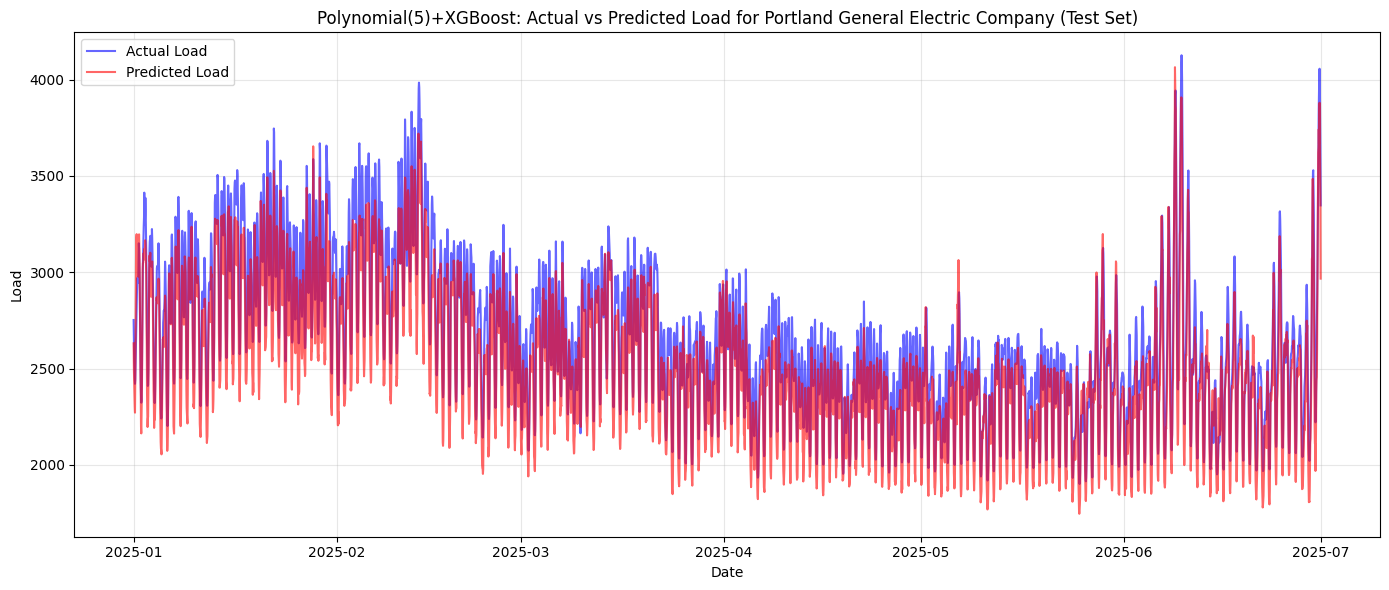


--- Processing City of Tacoma, Department of Public Utilities with Polynomial Regression ---
Data ranges from 2021-10-01 00:00:00 to 2025-08-22 05:00:00
Using 3 top features for polynomial regression out of 213 total features
Using 26 top features for XGBoost out of 213 total features
Training XGBoost on polynomial residuals...
Final results with polynomial(5) + XGBoost:
Train R²: 0.9964, Test R²: 0.9570
Train MAPE: 0.98%, Test MAPE: 3.40%
Validation R²: 0.9700, Validation MAPE: 2.52%


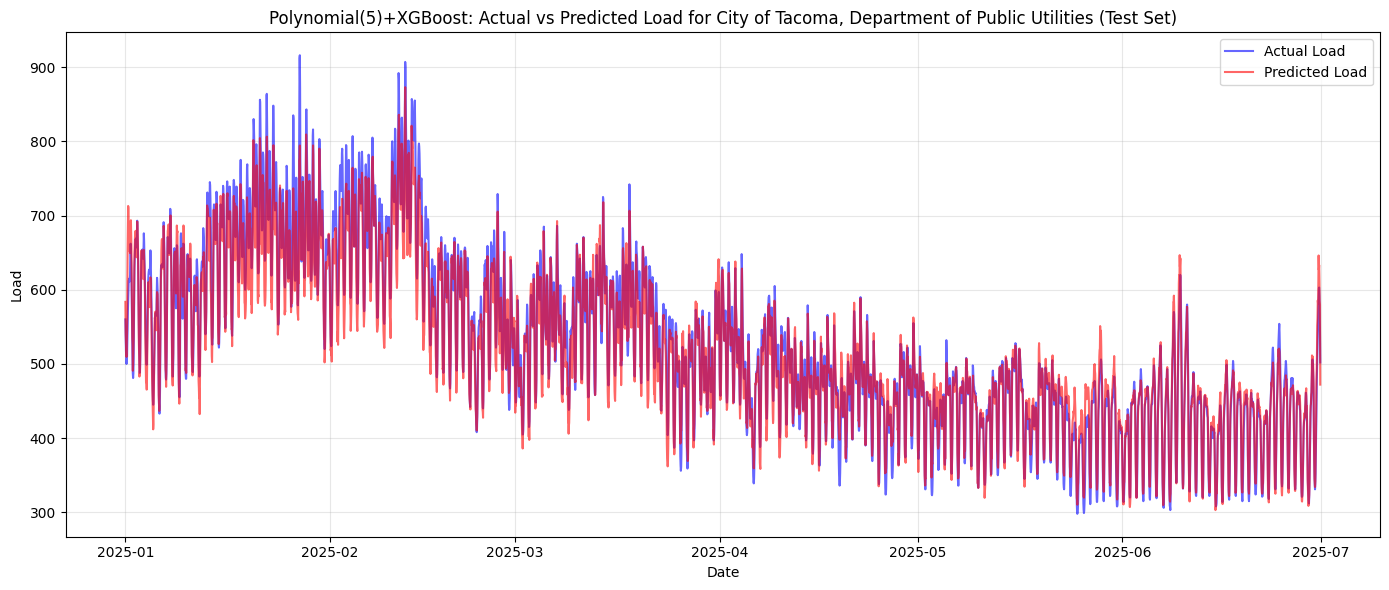


--- POLYNOMIAL + XGBOOST REGRESSION RESULTS ---
                                          Name Best Poly Order  Train R²  Test R²  Validation R²  Train MAPE  Test MAPE  Validation MAPE
                                          AVRN               5  1.000000 1.000000       1.000000         NaN        NaN              NaN
                      Puget Sound Energy, Inc.               5  0.993971 0.970526       0.968452    1.178712   2.701045         2.202555
City of Tacoma, Department of Public Utilities               5  0.996408 0.957030       0.970047    0.977333   3.395527         2.521172
                            Avista Corporation               5  0.992724 0.956014       0.928392    1.337288   3.101193         4.150703
                            Seattle City Light               5  0.988077 0.955828       0.952389    1.548165   3.097080         2.467935
                                      PACW-TAC               5  0.994602 0.951358       0.966872    0.985781   2.838833         2

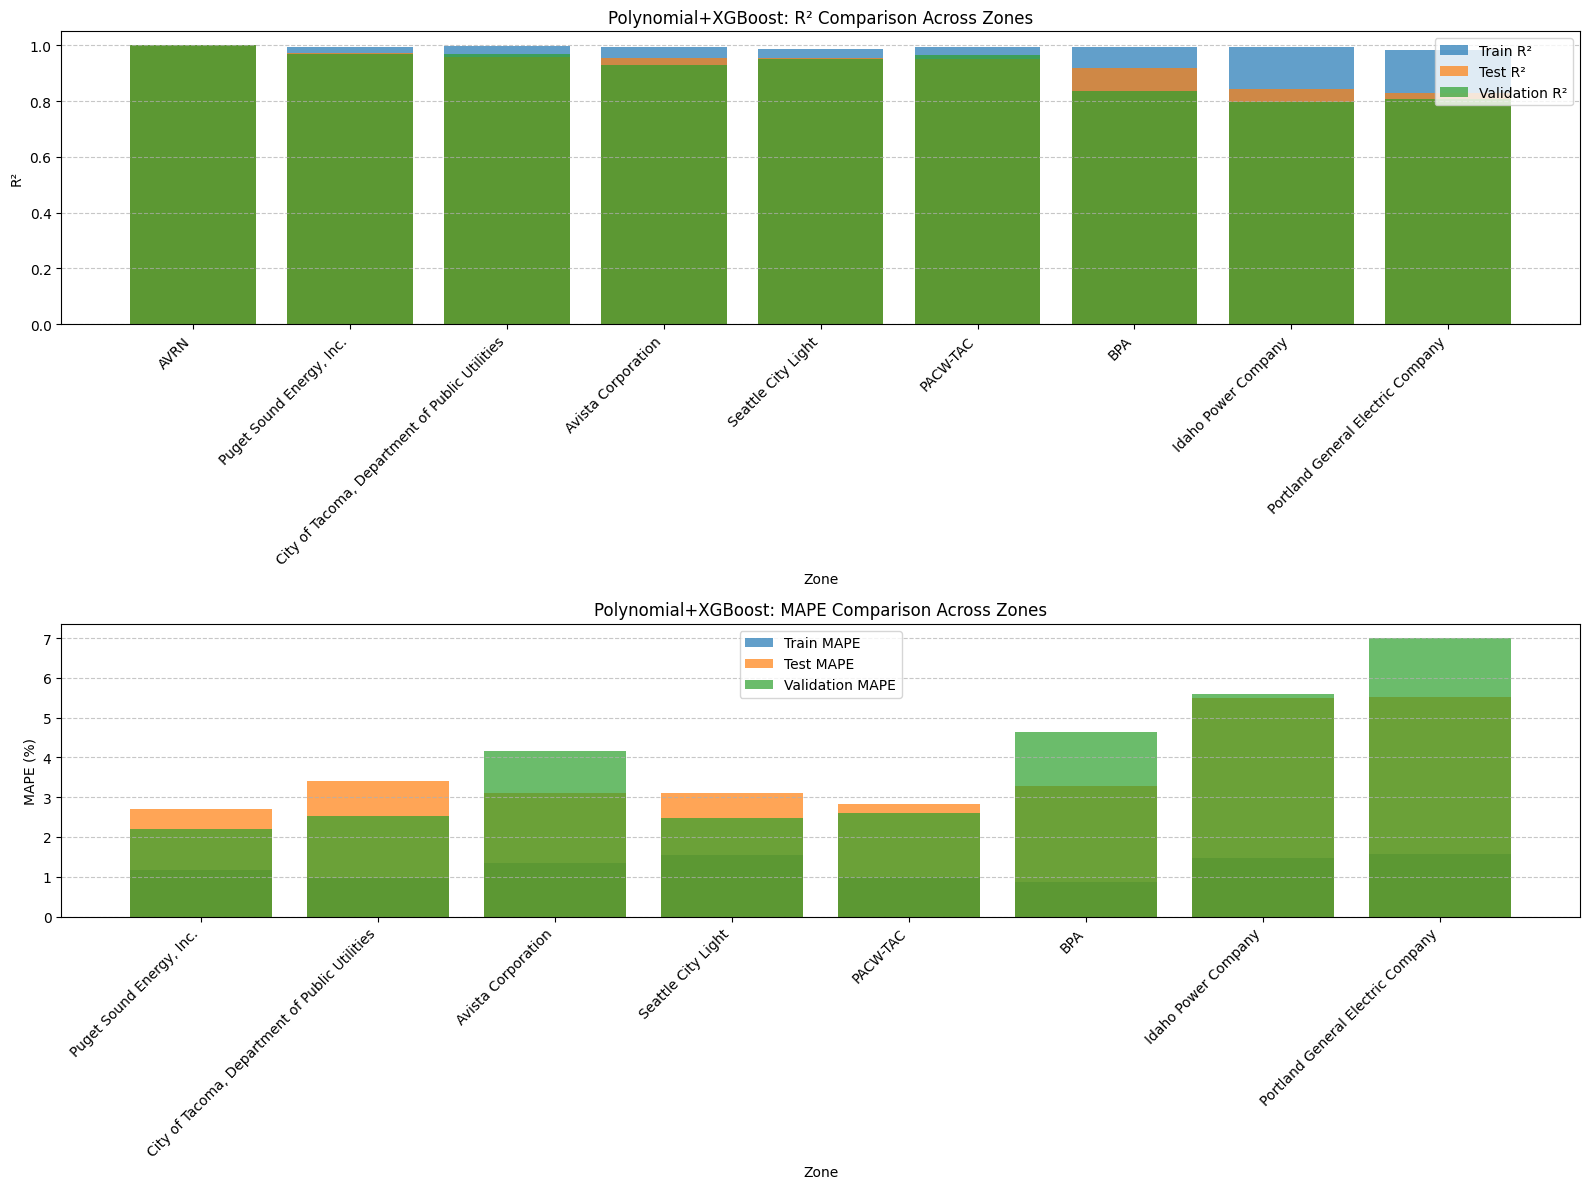

In [15]:
# Now let's add the cell for polynomial regression on top features:

# Load the best hyperparameters if not already in memory
if 'best_params_df' not in locals():
    best_params_df = pd.read_csv("NWPPZonalload_hyperparameters_with_validation.csv")

# Load the top features if not already in memory
if 'feature_importance_df' not in locals():
    feature_importance_df = pd.read_csv("all_zones_top_features.csv")

# Create a DataFrame to store results
poly_results_df = pd.DataFrame(columns=['Name', 'Best Poly Order', 'Train R²', 'Test R²', 'Validation R²', 'Train MAPE', 'Test MAPE', 'Validation MAPE'])

# Loop through each name
for name in unique_names:
    print(f"\n--- Processing {name} with Polynomial Regression ---")
    
    # Get best parameters for this zone
    zone_params = best_params_df[best_params_df['Name'] == name]
    if zone_params.empty:
        print(f"No hyperparameters found for {name}, skipping")
        continue
    
    # Parse the best parameters string
    best_params_str = zone_params['Best Parameters'].values[0]
    # Convert string representation of dict to actual dict
    import ast
    best_params = ast.literal_eval(best_params_str)
    
    # Get top features for this zone
    zone_features = feature_importance_df[feature_importance_df['Zone'] == name]['Feature'].tolist()
    
    # Select top 6.25% features for polynomial regression
    poly_features = zone_features[:len(zone_features)//16]  # Using 1/16 instead of 1/8 to get 6.25%
    
    # Select top 50% features for XGBoost
    xgb_features = zone_features[:len(zone_features)//2]
    
    if not poly_features or not xgb_features:
        print(f"Not enough top features found for {name}, skipping")
        continue
    
    # Use the totalload function to calculate the total load
    start_date = pd.to_datetime('2021-10-01')
    end_date = DFY[DFY['name']==name].dropna()['datetime'].max()

    print(f"Data ranges from {start_date} to {end_date}")
    dfY = DFY[(DFY['name']==name) & (DFY['datetime'] >= start_date) & (DFY['datetime'] <= end_date)].dropna().rename(columns={"avgvalue":"load"}).drop(columns=['name'])
    DFX_filtered = DFX[(DFX['datetime'] >= start_date) & (DFX['datetime'] <= end_date)]
    
    # Check if we have enough data
    if len(dfY) < 100:
        print(f"Not enough data for {name}, skipping")
        continue
    
    # Process data (same as before)
    # Drop nans from dfY['load']
    initial_len = len(dfY)
    dfY = dfY.dropna(subset=['load'])
    dropped_len = initial_len - len(dfY)
    if dropped_len > 0:
        print(f"Dropped {dropped_len} rows with NaN load values")
    
    # Get unique stations and columns to pivot
    stations = DFX_filtered['station_name'].unique()

    # Create a list to store dataframes for each station
    station_dfs = []

    # For each station, create a dataframe with properly named columns
    for station in stations:
        # Filter data for this station
        station_data = DFX_filtered[DFX_filtered['station_name'] == station]
        
        # Set datetime as index
        station_data = station_data.set_index('datetime')
        
        # Drop the station_name column
        station_data = station_data.drop('station_name', axis=1)
        
        # Rename columns to include station name
        station_data = station_data.rename(columns={col: f"{col}_{station}" for col in station_data.columns})
        
        # Add to list
        station_dfs.append(station_data)

    # Concatenate all station dataframes horizontally
    dfX = pd.concat(station_dfs, axis=1).reset_index()
    
    # Extract date and time components
    dfX['year'] = dfX['datetime'].dt.year
    dfX['month'] = dfX['datetime'].dt.month
    dfX['date'] = dfX['datetime'].dt.day
    dfX['day'] = dfX['datetime'].dt.dayofweek
    dfX['time'] = dfX['datetime'].dt.hour
    
    # Merge X and Y
    df_XY = pd.merge(dfX, dfY, on='datetime')
    
    # Feature Engineering and Selection
    target = 'load'
    exclude_cols = [target, 'Predicted Load', 'set', 'datetime']
    features = [col for col in df_XY.columns if col not in exclude_cols]
    
    # Filter to only use top features for polynomial regression
    valid_poly_features = [feat for feat in poly_features if feat in features]
    print(f"Using {len(valid_poly_features)} top features for polynomial regression out of {len(features)} total features")
    
    # Filter to use top features for XGBoost
    valid_xgb_features = [feat for feat in xgb_features if feat in features]
    print(f"Using {len(valid_xgb_features)} top features for XGBoost out of {len(features)} total features")
    
    # Define train/test/validation split based on year and month
    train_mask = df_XY['year'] < 2025
    test_mask = (df_XY['year'] == 2025) & (df_XY['month'] <= 6)
    validation_mask = (df_XY['year'] == 2025) & (df_XY['month'] > 6)
    
    # Skip if we don't have both train and test data
    if not train_mask.any() or not test_mask.any():
        print(f"Not enough train/test data for {name}, skipping")
        continue

    # Split data for polynomial regression
    X_poly_train = df_XY.loc[train_mask, valid_poly_features]
    X_poly_test = df_XY.loc[test_mask, valid_poly_features]
    X_poly_validation = df_XY.loc[validation_mask, valid_poly_features] if validation_mask.any() else None
    
    # Split data for XGBoost
    X_xgb_train = df_XY.loc[train_mask, valid_xgb_features]
    X_xgb_test = df_XY.loc[test_mask, valid_xgb_features]
    X_xgb_validation = df_XY.loc[validation_mask, valid_xgb_features] if validation_mask.any() else None
    
    y_train = df_XY.loc[train_mask, target]
    y_test = df_XY.loc[test_mask, target]
    y_validation = df_XY.loc[validation_mask, target] if validation_mask.any() else None

    # Handle missing values for polynomial features
    X_poly_train = X_poly_train.fillna(X_poly_train.median())
    X_poly_test = X_poly_test.fillna(X_poly_train.median())
    if X_poly_validation is not None:
        X_poly_validation = X_poly_validation.fillna(X_poly_train.median())
        
    # Handle missing values for XGBoost features
    X_xgb_train = X_xgb_train.fillna(X_xgb_train.median())
    X_xgb_test = X_xgb_test.fillna(X_xgb_train.median())
    if X_xgb_validation is not None:
        X_xgb_validation = X_xgb_validation.fillna(X_xgb_train.median())

    # Polynomial Regression on top features
    best_poly_order = 5  # Fixed polynomial degree of 5
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=best_poly_order, include_bias=False)
    X_train_poly = poly.fit_transform(X_poly_train)
    X_test_poly = poly.transform(X_poly_test)
    if X_poly_validation is not None:
        X_validation_poly = poly.transform(X_poly_validation)
    
    # Create and fit the polynomial model
    final_poly_model = LinearRegression()
    final_poly_model.fit(X_train_poly, y_train)
    
    # Calculate polynomial predictions
    y_train_poly_pred = final_poly_model.predict(X_train_poly)
    y_test_poly_pred = final_poly_model.predict(X_test_poly)
    if X_poly_validation is not None:
        y_validation_poly_pred = final_poly_model.predict(X_validation_poly)
    
    # Calculate residuals
    y_train_residuals = y_train - y_train_poly_pred
    y_test_residuals = y_test - y_test_poly_pred
    if X_poly_validation is not None:
        y_validation_residuals = y_validation - y_validation_poly_pred
    
    # Train XGBoost on residuals with more features
    print("Training XGBoost on polynomial residuals...")
    xgb_model = xgb.XGBRegressor(**best_params)
    xgb_model.fit(X_xgb_train, y_train_residuals)
    
    # Predict residuals
    y_train_residuals_pred = xgb_model.predict(X_xgb_train)
    y_test_residuals_pred = xgb_model.predict(X_xgb_test)
    if X_xgb_validation is not None:
        y_validation_residuals_pred = xgb_model.predict(X_xgb_validation)
    
    # Calculate final predictions (polynomial + residuals)
    y_train_pred = y_train_poly_pred + y_train_residuals_pred
    y_test_pred = y_test_poly_pred + y_test_residuals_pred
    if X_poly_validation is not None:
        y_validation_pred = y_validation_poly_pred + y_validation_residuals_pred
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    validation_r2 = None
    validation_mape = None
    if X_poly_validation is not None:
        validation_r2 = r2_score(y_validation, y_validation_pred)
        validation_mape = np.mean(np.abs((y_validation - y_validation_pred) / y_validation)) * 100
    
    print(f"Final results with polynomial({best_poly_order}) + XGBoost:")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")
    if validation_r2 is not None:
        print(f"Validation R²: {validation_r2:.4f}, Validation MAPE: {validation_mape:.2f}%")
    
    # Add to results DataFrame
    poly_results_df = poly_results_df._append({
        'Name': name,
        'Best Poly Order': best_poly_order,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Validation R²': validation_r2,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
        'Validation MAPE': validation_mape
    }, ignore_index=True)
    
    # Optional: Plot actual vs predicted for test data
    plt.figure(figsize=(14, 6))
    test_dates = df_XY.loc[test_mask, 'datetime']
    plt.plot(test_dates, y_test, 'b-', alpha=0.6, label='Actual Load')
    plt.plot(test_dates, y_test_pred, 'r-', alpha=0.6, label='Predicted Load')
    plt.title(f'Polynomial({best_poly_order})+XGBoost: Actual vs Predicted Load for {name} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Sort and display results
poly_results_df = poly_results_df.sort_values('Test R²', ascending=False)
print("\n--- POLYNOMIAL + XGBOOST REGRESSION RESULTS ---")
print(poly_results_df.to_string(index=False))

# Save results
poly_results_df.to_csv("polynomial_xgboost_results.csv", index=False)

# Plot comparison
plt.figure(figsize=(16, 12))

# Plot R² comparison
plt.subplot(2, 1, 1)
plt.bar(poly_results_df['Name'], poly_results_df['Train R²'], alpha=0.7, label='Train R²')
plt.bar(poly_results_df['Name'], poly_results_df['Test R²'], alpha=0.7, label='Test R²')
if 'Validation R²' in poly_results_df.columns and not poly_results_df['Validation R²'].isna().all():
    plt.bar(poly_results_df['Name'], poly_results_df['Validation R²'], alpha=0.7, label='Validation R²')
plt.xlabel('Zone')
plt.ylabel('R²')
plt.title('Polynomial+XGBoost: R² Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot MAPE comparison
plt.subplot(2, 1, 2)
plt.bar(poly_results_df['Name'], poly_results_df['Train MAPE'], alpha=0.7, label='Train MAPE')
plt.bar(poly_results_df['Name'], poly_results_df['Test MAPE'], alpha=0.7, label='Test MAPE')
if 'Validation MAPE' in poly_results_df.columns and not poly_results_df['Validation MAPE'].isna().all():
    plt.bar(poly_results_df['Name'], poly_results_df['Validation MAPE'], alpha=0.7, label='Validation MAPE')
plt.xlabel('Zone')
plt.ylabel('MAPE (%)')
plt.title('Polynomial+XGBoost: MAPE Comparison Across Zones')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [9]:
PolynomialFeatures

sklearn.preprocessing._polynomial.PolynomialFeatures